In [1]:
# goal: generate realistic wind profiles for different halo masses given 1e9.7 satellite galaxy
# steps: 1. host potentials (1e12 - 1e15) cf Donnari simulations 
# 2. initial velocity conditions cf Wetzel 2011 (v_r, v_theta)
# 3. orbital integration --> time dependent velocities and positions
# 4. density and temperature profiles --> analytic beta profiles for density

In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic, solarsystem, dimensionless
from astropy.constants import G
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy import constants as const
from matplotlib.ticker import AutoMinorLocator
#import galpy
#from galpy import potential as gp
#from galpy.orbit import Orbit

from scipy.integrate import quad

plt.rc('font', size=14)

In [3]:
plt_dir = '../paper_plots/'

## 1. NFW Halo Potentials

In [4]:
# constants

# critical density
rho_c = 3 * cosmo.H(0.)**2 / (8*np.pi*G)
rho_c = rho_c.to(u.Msun/u.kpc**3)
print ('critical density from cosmology:',rho_c, '\n')

# gravitational constant in galactic units
G_galactic = 4.30091e-6 # kpc/Msun(km/s)**2
print ('G in cgs units:',G.cgs,'\n',
       'G in galactic units [kpc/Msun(km/s)**2]',G_galactic)

G = const.G.cgs
mean_molecular_mass = 0.62 # for ionized gas
kB = const.k_B.cgs

critical density from cosmology: 127.05281539749838 solMass / kpc3 

G in cgs units: 6.674299999999999e-08 cm3 / (g s2) 
 G in galactic units [kpc/Msun(km/s)**2] 4.30091e-06


In [5]:
# mass grid from Donnari host halo range
# NFW concentration values are approximated from Ludlow+ 2014 m-c-z relations at z=0
# update 01/23/2022: revised Ludlow+ figure axis reading by little h

M_host_halos = np.array([1.e12, 1.e13, 1.e14]) *u.Msun
#c_NFW_host_halos = np.array([10**0.975, 10**0.875, 10**0.75]) 
# little h revision now completed for Ludlow graph reading
# there is a mild z dependence -- beware! z=1 ~ 7.731 Gyr
c_NFW_host_halos = np.array([10**0.945, 10**0.85, 10**0.75]) 

Rvir_host_halos = np.zeros(len(M_host_halos))
r100_host_halos = np.zeros(len(M_host_halos))
r500_host_halos = np.zeros(len(M_host_halos))
r_s_NFW_host_halos = np.zeros(len(M_host_halos))
Vvir_host_halos = np.zeros(len(M_host_halos))

print ('Mass (1e12); Concentration; Rvir [kpc]; r100 [kpc]; r500 [kpc]; r_s [kpc]; V_vir [km/s]:')
for i, mass in enumerate(M_host_halos):
    mass = mass.value
    Rvir_host_halos[i] = np.cbrt(mass / (200*rho_c.value) / (4/3*np.pi))
    r100_host_halos[i] = np.cbrt(mass / (100*rho_c.value) / (4/3*np.pi))
    r500_host_halos[i] = np.cbrt(mass / (500*rho_c.value) / (4/3*np.pi))
    r_s_NFW_host_halos[i] = Rvir_host_halos[i] / c_NFW_host_halos[i]
    Vvir_host_halos[i] = np.sqrt(G_galactic*mass/Rvir_host_halos[i])
    print (mass/1.e12, np.around(c_NFW_host_halos[i],3), 
           np.around(Rvir_host_halos[i],2),'kpc;',
           np.around(r100_host_halos[i],2), 'kpc;',
           np.around(r500_host_halos[i],2), 'kpc;',
           np.around(r_s_NFW_host_halos[i],2),'kpc;',
           np.around(Vvir_host_halos[i],2), 'km/s.')

Mass (1e12); Concentration; Rvir [kpc]; r100 [kpc]; r500 [kpc]; r_s [kpc]; V_vir [km/s]:
1.0 8.81 211.01 kpc; 265.85 kpc; 155.47 kpc; 23.95 kpc; 142.77 km/s.
10.0 7.079 454.6 kpc; 572.76 kpc; 334.95 kpc; 64.21 kpc; 307.58 km/s.
100.0 5.623 979.41 kpc; 1233.98 kpc; 721.64 kpc; 174.17 kpc; 662.67 km/s.


### NFW Initialization: $M_{200}-c$ (this is the paper version)

In [6]:
# NFW scale radii from mass-concentration-z relation cf Ludlow+ 2013
# mass grid from Donnari host halo range
# using Gala M200 and concentration initialization, this is more appropriate for our purposes

pot_halo_1e12_alt = gp.NFWPotential.from_M200_c(M200=M_host_halos[0], c=c_NFW_host_halos[0], units=galactic)
pot_halo_1e13_alt = gp.NFWPotential.from_M200_c(M200=M_host_halos[1], c=c_NFW_host_halos[1], units=galactic)
pot_halo_1e14_alt = gp.NFWPotential.from_M200_c(M200=M_host_halos[2], c=c_NFW_host_halos[2], units=galactic)
#pot_halo_1e15_alt = gp.NFWPotential.from_M200_c(M200=M_host_halos[3], c=c_NFW_host_halos[3], units=galactic)

In [7]:
# print M100 -- enclosed mass at r100 for Komatsu and Seljak model
# test NFW initialization methods

# length grids
r = np.logspace(-2, 3, 1000) * u.kpc
pos = np.zeros((3, 1000))
pos[0] = r


r100_radius_index_1e12  = np.argmin(abs(r.value - r100_host_halos[0]))
r100_radius_index_1e13  = np.argmin(abs(r.value - r100_host_halos[1]))
r100_radius_index_1e14  = np.argmin(abs(r.value - r100_host_halos[2]))

m100_1e12 = pot_halo_1e12_alt.mass_enclosed(pos)[r100_radius_index_1e12]
m100_1e13 = pot_halo_1e13_alt.mass_enclosed(pos)[r100_radius_index_1e13]
m100_1e14 = pot_halo_1e14_alt.mass_enclosed(pos)[r100_radius_index_1e14]

print ('M100 halo masses =',m100_1e12,m100_1e13,m100_1e14,'\n',
       np.log10(m100_1e12.value),
      np.log10(m100_1e13.value),
       np.log10(m100_1e14.value))

print ('r100/Rvir =',r100_host_halos/Rvir_host_halos)

M100 halo masses = 1137206317137.7292 solMass 11529530681544.254 solMass 101444129525628.95 solMass 
 12.055839263514391 13.06181162936201 14.006226919891859
r100/Rvir = [1.25992105 1.25992105 1.25992105]


In [8]:
# print M500 -- enclosed mass at r500 for Komatsu and Seljak model

r500_radius_index_1e12  = np.argmin(abs(r.value - r500_host_halos[0]))
r500_radius_index_1e13  = np.argmin(abs(r.value - r500_host_halos[1]))
r500_radius_index_1e14  = np.argmin(abs(r.value - r500_host_halos[2]))

m500_1e12 = pot_halo_1e12_alt.mass_enclosed(pos)[r500_radius_index_1e12]
m500_1e13 = pot_halo_1e13_alt.mass_enclosed(pos)[r500_radius_index_1e13]
m500_1e14 = pot_halo_1e14_alt.mass_enclosed(pos)[r500_radius_index_1e14]

print ('M500 halo masses =',m500_1e12,m500_1e13,m500_1e14,'\n',
       np.log10(m500_1e12.value),
      np.log10(m500_1e13.value),
       np.log10(m500_1e14.value))

print ('r500/Rvir =',r500_host_halos/Rvir_host_halos)

M500 halo masses = 825051212817.879 solMass 8138516333063.54 solMass 80111816018840.1 solMass 
 11.916480907039507 12.910545239398676 13.903696576674987
r500/Rvir = [0.7368063 0.7368063 0.7368063]


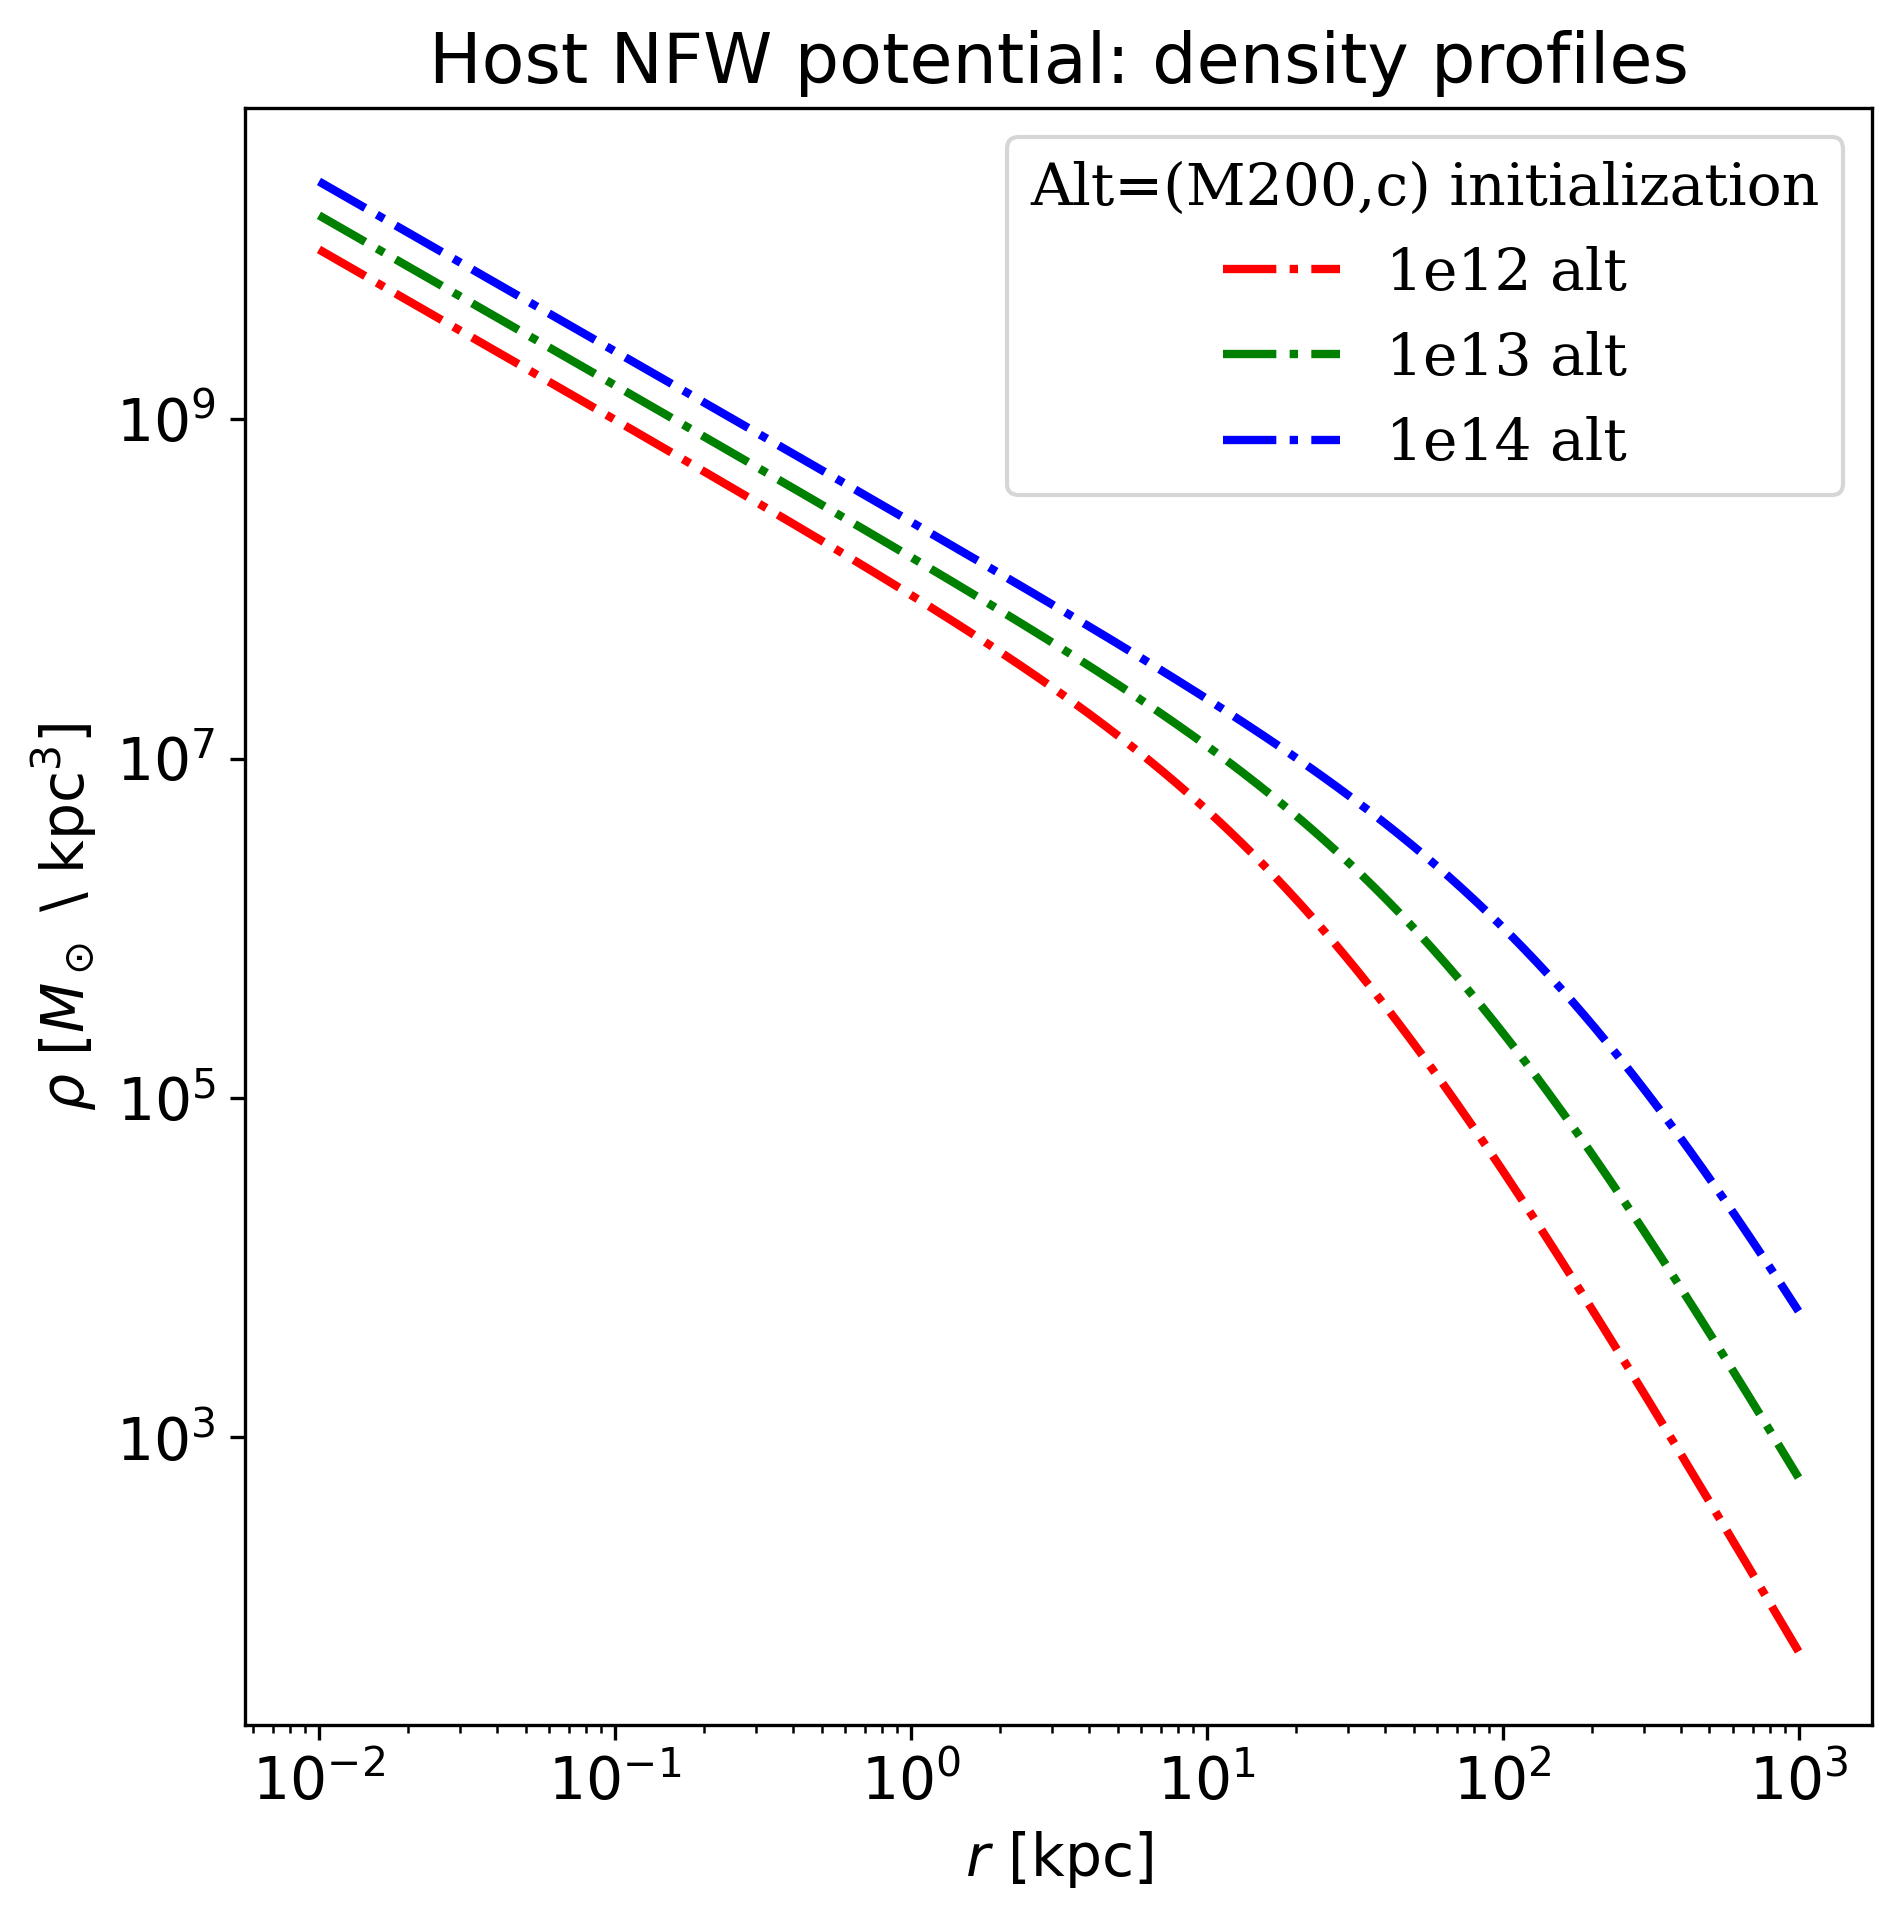

In [9]:
# visualize the potential and density profiles

dens_alt_1e12 = pot_halo_1e12_alt.density(pos)

dens_alt_1e13 = pot_halo_1e13_alt.density(pos)

dens_alt_1e14 = pot_halo_1e14_alt.density(pos)

#dens_1e15 = pot_halo_1e15.density(pos)
#dens_alt_1e15 = pot_halo_1e15_alt.density(pos)

fig,ax = plt.subplots(1, 1, figsize=(7,7),dpi=300)
plt.rcParams["font.family"] = "serif"

ax.loglog(r.value, dens_alt_1e12.value, 'r-.',lw=2,label='1e12 alt')


ax.loglog(r.value, dens_alt_1e13.value, 'g-.',lw=2,label='1e13 alt')


ax.loglog(r.value, dens_alt_1e14.value, 'b-.',lw=2,label='1e14 alt')

plt.legend(ncol=1, title='Alt=(M200,c) initialization')
ax.set_xlabel("$r$ [kpc]") 
ax.set_ylabel(r"$\rho$ [$M_\odot$ \ kpc$^3$]") 
ax.set_title('Host NFW potential: density profiles')
#plt.savefig('nfw_density_profiles.png')
plt.show()

## 2. Test Orbits

In [10]:
# velocity inputs from the Wetzel paper, evaluated at the host virial radii
# two-body central force problem with numerical fitting for velocity vs host mass profiles
# satellite mass fit from Wu paper, input stellar mass 10**9.7 ~ 5.e9 solar masses
# sat total mass slightly higher than Wetzel paper range!
# updated 01/23/2022 correcting for little h (h=0.72)

Mh_sat = 2.e11 *u.Msun
mu = Mh_sat*M_host_halos/(Mh_sat+M_host_halos)
print (mu)

# directly read from Wetzel paper
# velocity components at R200 in units of V200 (initial conditions) 
V_theta_frac = np.array([0.655, 0.603, 0.53])
V_theta = V_theta_frac * Vvir_host_halos

V_radial_frac  = np.array([0.832, 0.786, 0.782])
V_radial = V_radial_frac * Vvir_host_halos

# these are the total velocity values from the Wetzel paper (not in use, but for sanity check)
V_sat_tot     = np.array([1.112, 1.043, 0.99])
print ('derived |V|',np.sqrt(V_radial_frac**2 + V_theta_frac**2)*Vvir_host_halos,'\n',
       'Wetzel |V|',V_sat_tot*Vvir_host_halos,'\n',
      'Vphi,0',V_theta,'\n',
       '|Vr,0|',V_radial)

[1.66666667e+11 1.96078431e+11 1.99600798e+11] solMass
derived |V| [151.17559783 304.71099606 626.01241715] 
 Wetzel |V| [158.7579373  320.81029907 656.04332585] 
 Vphi,0 [ 93.51299365 185.47326015 351.21511384] 
 |Vr,0| [118.78291712 241.76116497 518.20796042]


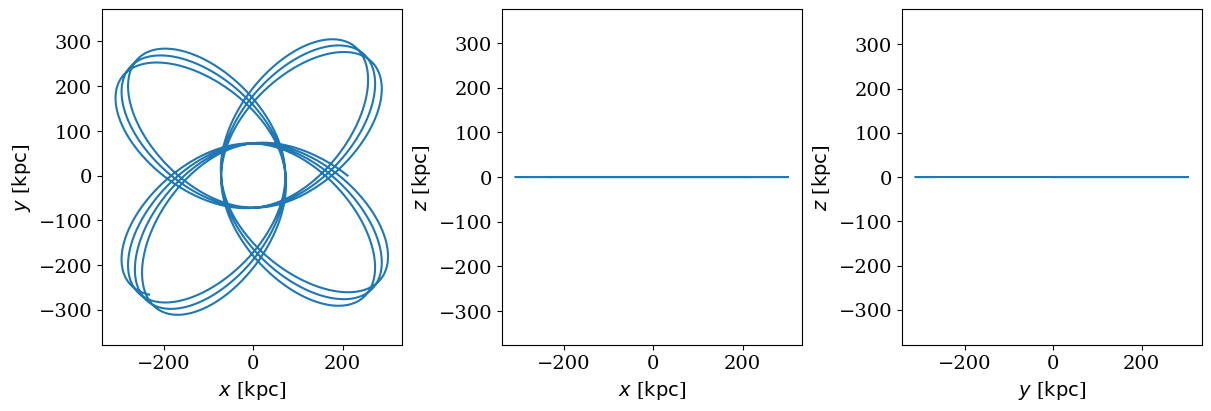

In [11]:
# note: default frame is Cartesian

# 1e12 halo
pos = [Rvir_host_halos[0], 0, 0] *u.kpc
vel = [-1*V_radial[0], V_theta[0], 0]*u.km / u.s

# initial conditions
w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

# orbit integration
orbit_1e12 = gp.Hamiltonian(pot_halo_1e12_alt).integrate_orbit(w0, dt=1., n_steps=100000)
fig = orbit_1e12.plot()
plt.show()

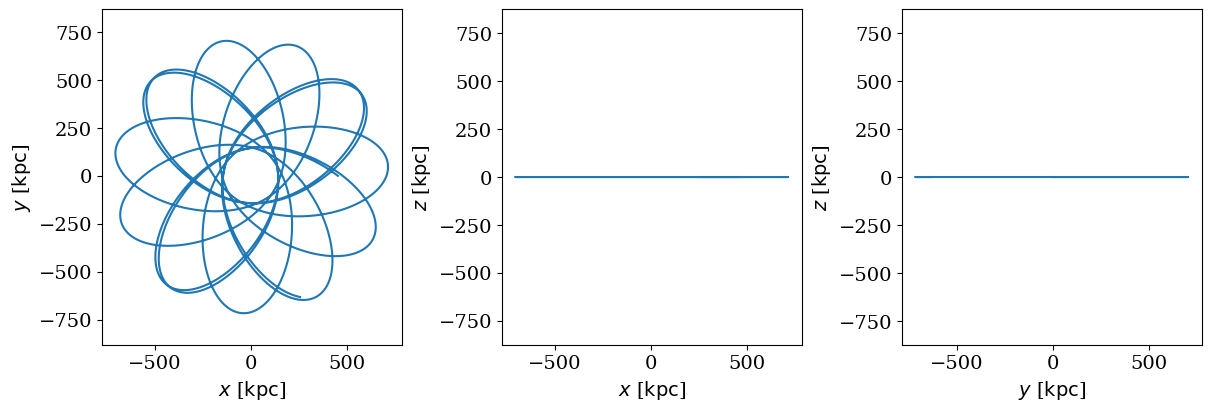

In [12]:
# 1e13 halo
pos = [Rvir_host_halos[1], 0, 0] *u.kpc
vel = [-1*V_radial[1], V_theta[1], 0]*u.km / u.s

# initial conditions
w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

# orbit integration
orbit_1e13 = gp.Hamiltonian(pot_halo_1e13_alt).integrate_orbit(w0, dt=1., n_steps=100000)
fig = orbit_1e13.plot()
plt.show()

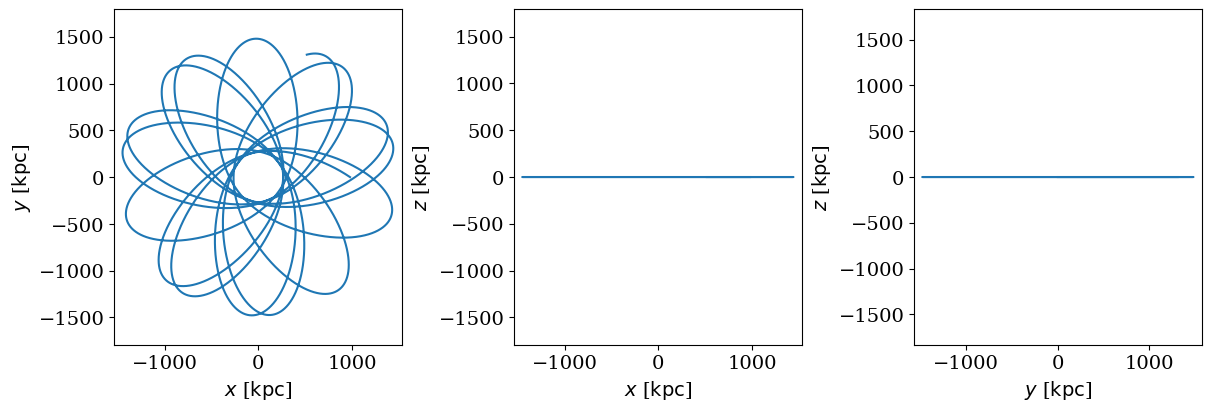

In [13]:

# 1e14 halo
pos = [Rvir_host_halos[2], 0, 0] *u.kpc
vel = [-1*V_radial[2], V_theta[2], 0]*u.km / u.s

# initial conditions
w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

# orbit integration
orbit_1e14 = gp.Hamiltonian(pot_halo_1e14_alt).integrate_orbit(w0, dt=1., n_steps=100000)
fig = orbit_1e14.plot()
#plt.savefig('orbit.png')
plt.show()

In [14]:
orbit_1e13.t

<Quantity [0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 9.9998e+04, 9.9999e+04,
           1.0000e+05] Myr>

In [15]:
orbit_1e12.vel*u.kpc.to(u.km)/u.Myr.to(u.s)

<CartesianDifferential (d_x, d_y, d_z) in kpc / Myr
    [(-118.78291712,  93.51299365, 0.), (-118.88174826,  93.51297123, 0.),
     (-118.98066016,  93.51290391, 0.), ...,
     (  62.3630024 , -13.45754518, 0.), (  62.39345402, -13.42278475, 0.),
     (  62.42390418, -13.38801468, 0.)]>

In [16]:
print (orbit_1e12.eccentricity(),
      orbit_1e13.eccentricity(),
      orbit_1e14.eccentricity())

0.6728653462382274 0.6680743405158741 0.6956465878713747


In [17]:
vel_1e12 = (np.sqrt(orbit_1e12.vel.d_x**2+orbit_1e12.vel.d_y**2)*u.kpc.to(u.km)/u.Myr.to(u.s)).value # km/s
vel_1e13 = (np.sqrt(orbit_1e13.vel.d_x**2+orbit_1e13.vel.d_y**2)*u.kpc.to(u.km)/u.Myr.to(u.s)).value # km/s
vel_1e14 = (np.sqrt(orbit_1e14.vel.d_x**2+orbit_1e14.vel.d_y**2)*u.kpc.to(u.km)/u.Myr.to(u.s)).value # km/s
orbital_time = orbit_1e12.t

In [18]:
# example inflow time from Stephanie non-cooling inflow file

print ('Maximum inflow time in Myr (spread between 1100 steps)=', 2.519726e+16/3.14e7/1.e6,'[Myr]')
print ('Total orbital info we have:',orbit_1e12.t, orbit_1e12.t.shape,'\n',
      'Needs 1001 steps to reach 1000 Myr \n',
      orbit_1e12.t[:1001])

Maximum inflow time in Myr (spread between 1100 steps)= 802.4605095541401 [Myr]
Total orbital info we have: [0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05] Myr (100001,) 
 Needs 1001 steps to reach 1000 Myr 
 [   0.    1.    2. ...  998.  999. 1000.] Myr


### Obtaining first infall orbit duration

1300 Myr does capture pericenter for all three orbits! (t_infall < 1300 Myr)


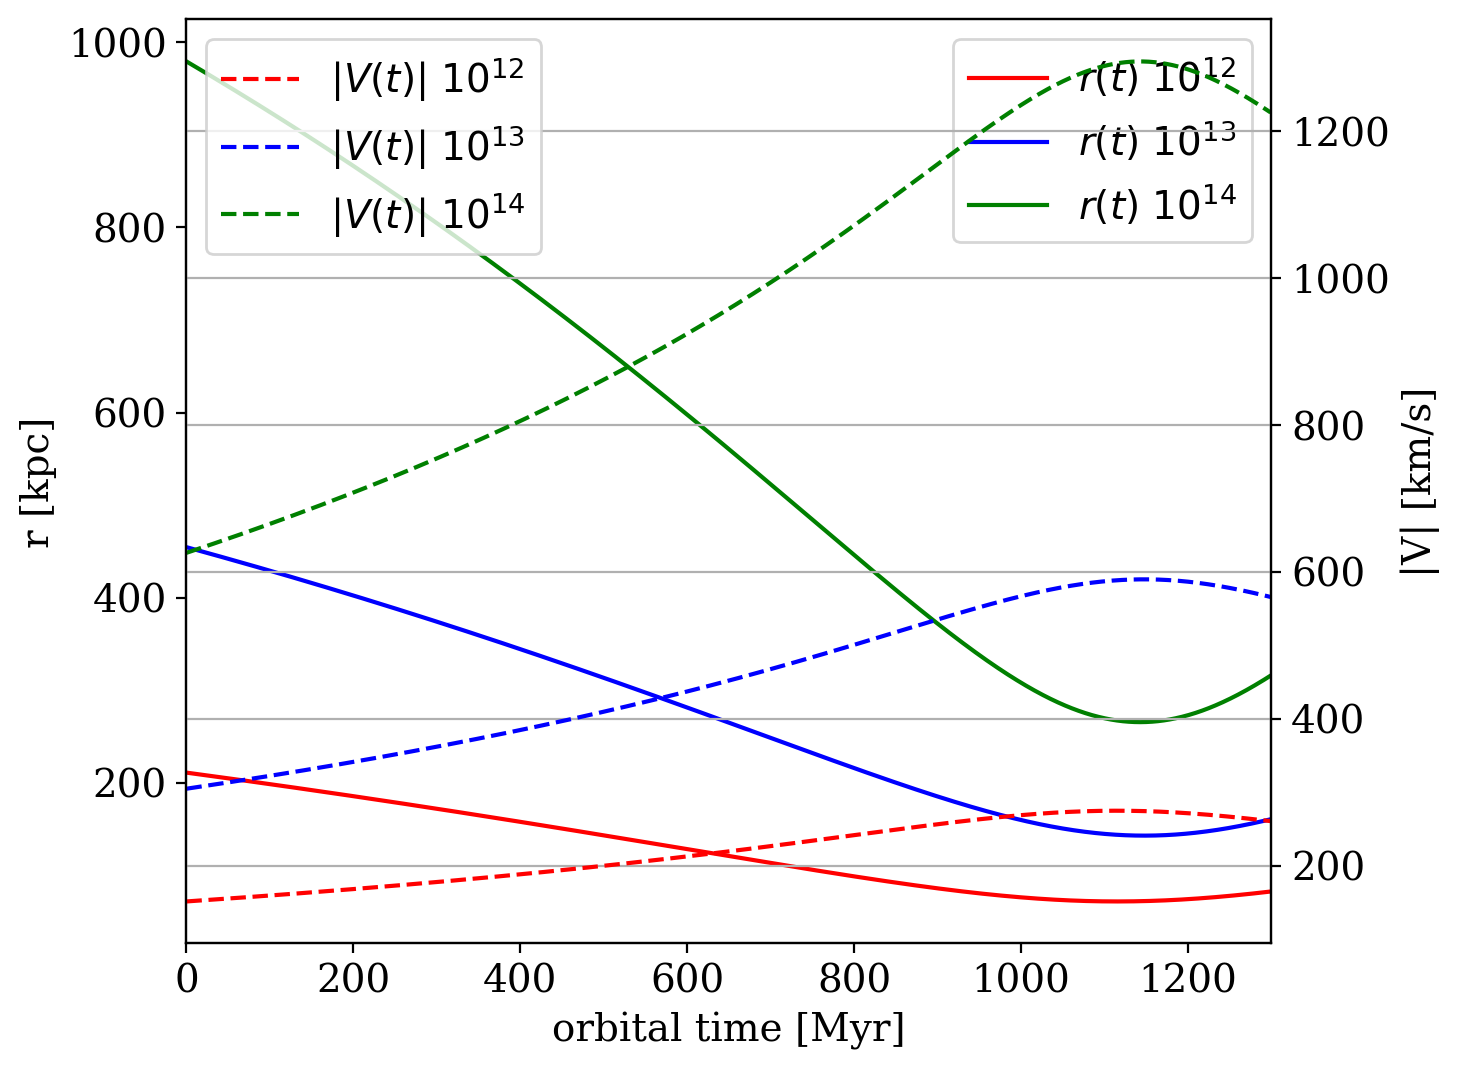

In [19]:
# find densities at r(t) from 0 to 1000 Myr
# define a time series... what kind of dynamical time are we modeling? up to one Gyr? (first infall)

orbit_1e12_r = np.sqrt(orbit_1e12.pos.x**2 + orbit_1e12.pos.y**2)
orbit_1e13_r = np.sqrt(orbit_1e13.pos.x**2 + orbit_1e13.pos.y**2)
orbit_1e14_r = np.sqrt(orbit_1e14.pos.x**2 + orbit_1e14.pos.y**2)

orbit_ind_first_infall_bound = 1300
# visualize the time series for relevant scale (Gyr)
fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=200)
plt.xlabel('orbital time [Myr]')
plt.plot(orbit_1e12.t[:orbit_ind_first_infall_bound], 
         orbit_1e12_r[:orbit_ind_first_infall_bound], 'r-',label=r'$r(t)$ $10^{12}$')

plt.plot(orbit_1e13.t[:orbit_ind_first_infall_bound], 
         orbit_1e13_r[:orbit_ind_first_infall_bound], 'b-',label=r'$r(t)$ $10^{13}$')

plt.plot(orbit_1e14.t[:orbit_ind_first_infall_bound], 
         orbit_1e14_r[:orbit_ind_first_infall_bound], 'g-',label=r'$r(t)$ $10^{14}$')

plt.legend()
plt.ylabel('r [kpc]')
ax2 = ax.twinx()
ax2.grid(True)
ax2.plot(orbit_1e12.t[:orbit_ind_first_infall_bound], vel_1e12[:orbit_ind_first_infall_bound],
         'r--', label=r'|$V(t)$| $10^{12}$')
ax2.plot(orbit_1e13.t[:orbit_ind_first_infall_bound], vel_1e13[:orbit_ind_first_infall_bound],
         'b--', label=r'|$V(t)$| $10^{13}$')
ax2.plot(orbit_1e14.t[:orbit_ind_first_infall_bound], vel_1e14[:orbit_ind_first_infall_bound],
         'g--', label=r'|$V(t)$| $10^{14}$')

ax2.set_ylabel('|V| [km/s]')
plt.legend()
plt.xlim(0,1300)
print ('1300 Myr does capture pericenter for all three orbits! (t_infall < 1300 Myr)')
plt.show()

In [20]:
# update 0501/2022, adding a small routine here to find the accurate first infall period
# caution: this is NOT related to the orbital period and smaller than half the period: starting from Rvir not apo!

# from the orbit time series above, it is safe to assume all three ts reach pericenter before 1300 Myr
# locate a local maximum in velocity/minimum in radius in between 0-1300 Myr

# assert that r(t) and v(t) extrema are found in sync
first_infall_ind_1e12 = np.argmin(orbit_1e12_r[:orbit_ind_first_infall_bound])
assert first_infall_ind_1e12 == np.argmax(vel_1e12[:orbit_ind_first_infall_bound]) 
print ('1e12 halo time [Myr] for first infall =',first_infall_ind_1e12,'\n',
       'orbital radius at pericenter [kpc] =',orbit_1e12_r[first_infall_ind_1e12],'\n',
      'velocity at pericenter [km/s] =',vel_1e12[first_infall_ind_1e12],'\n')

# similarly for 1e13
first_infall_ind_1e13 = np.argmin(orbit_1e13_r[:orbit_ind_first_infall_bound])
assert first_infall_ind_1e13 == np.argmax(vel_1e13[:orbit_ind_first_infall_bound]) 
print ('1e13 halo time [Myr] for first infall =',first_infall_ind_1e13,'\n',
       'orbital radius at pericenter [kpc] =',orbit_1e13_r[first_infall_ind_1e13],'\n',
      'velocity at pericenter [km/s] =', vel_1e13[first_infall_ind_1e13],'\n')

# similarly for 1e14
first_infall_ind_1e14 = np.argmin(orbit_1e14_r[:orbit_ind_first_infall_bound])
assert first_infall_ind_1e14 == np.argmax(vel_1e14[:orbit_ind_first_infall_bound]) 
print ('1e14 halo time [Myr] for first infall =',first_infall_ind_1e14,'\n',
       'orbital radius at pericenter [kpc] =',orbit_1e14_r[first_infall_ind_1e14],'\n',
      'velocity at pericenter [km/s] =',vel_1e14[first_infall_ind_1e14],'\n' )

print ('passed all assert test -- found the time at pericenter for all cases!')

1e12 halo time [Myr] for first infall = 1115 
 orbital radius at pericenter [kpc] = 71.8191186412267 kpc 
 velocity at pericenter [km/s] = 274.7457194715863 

1e13 halo time [Myr] for first infall = 1148 
 orbital radius at pericenter [kpc] = 142.93330517959708 kpc 
 velocity at pericenter [km/s] = 589.9028562898189 

1e14 halo time [Myr] for first infall = 1143 
 orbital radius at pericenter [kpc] = 265.5613910119391 kpc 
 velocity at pericenter [km/s] = 1295.3115733994034 

passed all assert test -- found the time at pericenter for all cases!


## Orbit eccentricities are on the low side
--- 
FoF halo mass definition in Wetzel paper is different from M200 (spherical overdensity), within a (reported) 15 percent error. Our orbital integration shows lower than predicted eccentricities (e$\sim$0.85) in that we obtained e $\sim$ 0.68

# 3. ICM/CGM Density Profiles
---
The $\beta$ model reads like:
\begin{equation}
    n_{gas}(r) = n_{gas,0} [1+(\frac{r}{r_{c}})^{2}]^{-3 \beta/2}
\end{equation}
In our case we have $\vec{r}$ already from the orbital parameters. Needs to calculated $n(r)$ from $r_{c}$, $n_{0}$, as well as $\beta$.

## 3.1 The $10^{12}$ Milky Way Halo Case

In [21]:
# cf Miller and Bregman (2013) numerical fitting to MW gaseous halo profile
n_0 = 0.46 # cm^-3
r_c = 0.35 * u.kpc # kpc
beta = 0.71
# beta = 0.5
mu = const.u.cgs
Msun = const.M_sun.cgs
valid_position_index = np.argmin(abs(r - r_c)) + 1
print (mu, valid_position_index)

1.6605390666e-24 g 310


In [22]:
# show mass profile scaled by Msun
# Miller and Bregman 2013 beta model fitting
n_r_MB13 = n_0 * (1. + (r/r_c)**2) ** (-3.*beta/2.)

In [23]:
# previous MB13 density too low
# cf the updated density profile from Miller and Bregman (2015)

n0_rc_3beta = 1.35*1e-2 # new constraint
beta_oviii = 0.5
n_r_MB15 = n0_rc_3beta/r**(3.*beta_oviii) # equation (2)

Salem15_ne = 1.1e-4

In [24]:
# constant factor between M-B15 and Salem15
ne_factor = Salem15_ne / (n_r_MB15[valid_position_index:][np.argmin(abs(r.value[valid_position_index:] - 48.2))])
print (ne_factor.value)
print ('Final, in-used n_0 for the MW case is MB15 fitted to Salem15:', n0_rc_3beta*ne_factor.value)

2.7326527164468324
Final, in-used n_0 for the MW case is MB15 fitted to Salem15: 0.036890811672032245


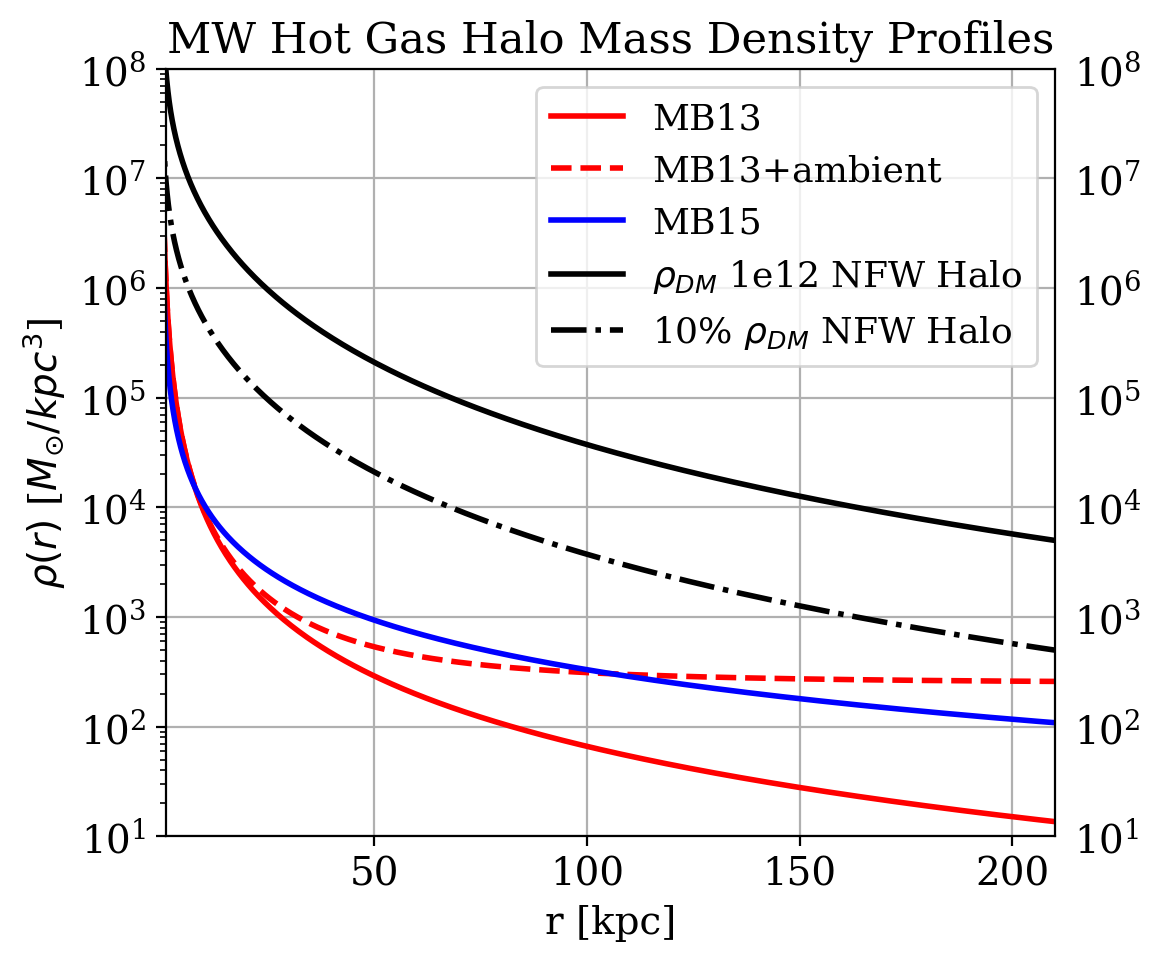

In [25]:
# mass density derived from number density
mass_r_MB13 = n_r_MB13 * mu *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3 # g/cm3 --> Msun/kpc^3
mass_r_with_ambient = (n_r_MB13+1.e-5) * mu *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3 # g/cm3 --> Msun/kpc^3 
mass_r_MB15 = n_r_MB15 * mu *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3 # g/cm3 --> Msun/kpc^3

fig,ax = plt.subplots(1, 1, figsize=(6,5),dpi=200)
plt.rc('font', size=13)
plt.grid(True)
plt.title('beta profile test MW halo')
plt.plot(r, mass_r_MB13, 'r-',lw=2,label='MB13')
plt.plot(r, mass_r_with_ambient, 'r--',lw=2,label=r'MB13+ambient')
plt.plot(r, mass_r_MB15, 'b-',lw=2,label=r'MB15')
plt.plot(r.value, dens_alt_1e12.value, 'k-',lw=2,label=r'$\rho_{DM}$ 1e12 NFW Halo')
plt.plot(r.value, dens_alt_1e12.value/10., 'k-.',lw=2,label=r'10% $\rho_{DM}$ NFW Halo')
#plt.loglog()
plt.yscale('log')
plt.tick_params(labelright=True)
plt.xlim(1,210)
plt.ylim(10,10**8)
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel(r'$\rho(r)$ [$M_{\odot}/kpc^{3}$]')
plt.title('MW Hot Gas Halo Mass Density Profiles')
plt.tight_layout()
#plt.savefig('MW_mass_density_models.png')
plt.show()
#plt.xlim(1, 200)

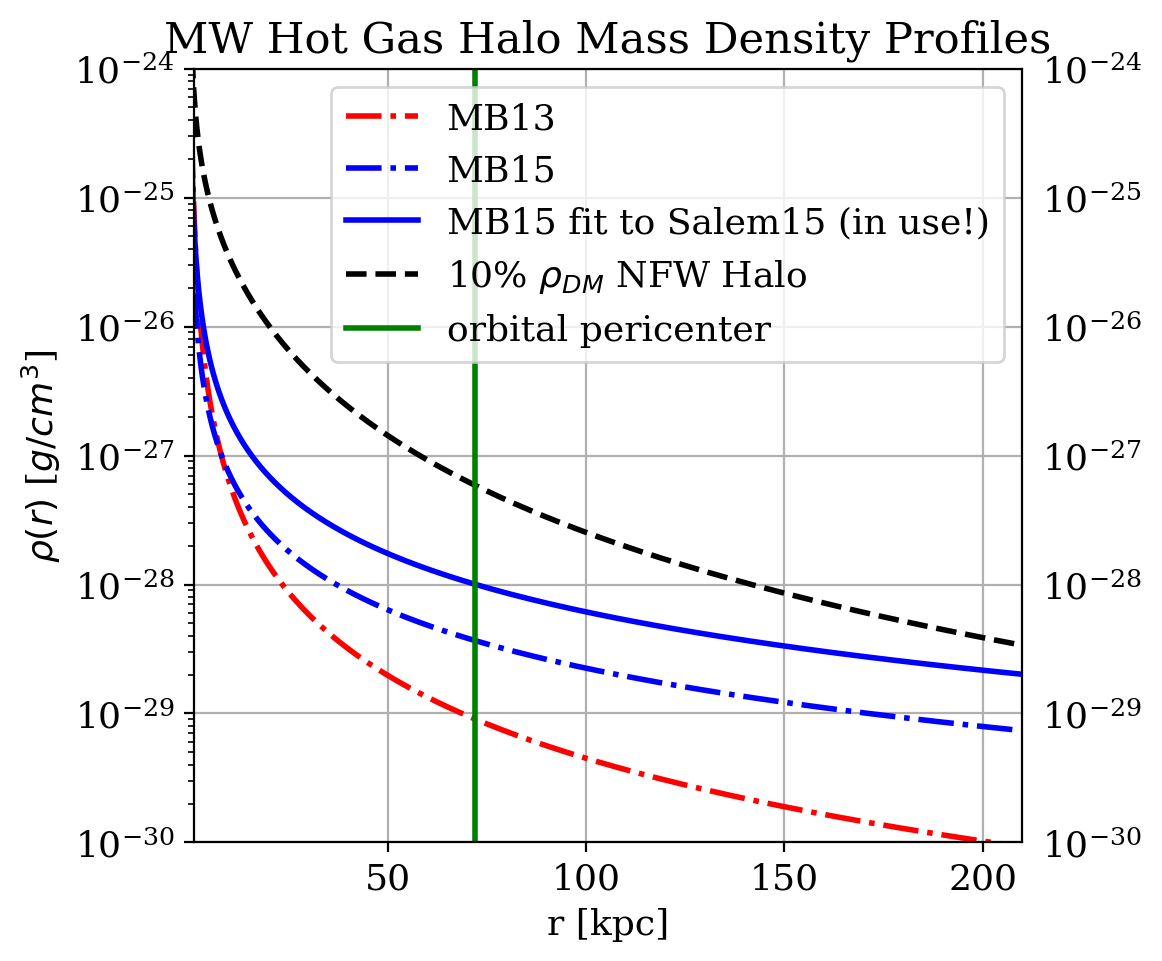

In [26]:
# mass density derived from number density
# the same mass density profile plot but in cgs units
mass_r_MB13_cgs = n_r_MB13 * mu  # g/cm3 --> Msun/kpc^3
#mass_r_with_ambient = (n_r_MB13+1.e-5) * mu *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3 # g/cm3 --> Msun/kpc^3 
mass_r_MB15_cgs = n_r_MB15 * mu # g/cm3 --> Msun/kpc^3

fig,ax = plt.subplots(1, 1, figsize=(6,5),dpi=200)
plt.rc('font', size=13)
plt.grid(True)
plt.title('beta profile test MW halo')
plt.plot(r, mass_r_MB13_cgs, 'r-.',lw=2,label='MB13')
#plt.plot(r, mass_r_with_ambient, 'r--',lw=2,label=r'MB13+ambient')
plt.plot(r, mass_r_MB15_cgs, 'b-.',lw=2,label=r'MB15')
plt.plot(r, mass_r_MB15_cgs*ne_factor, 'b-',lw=2,label=r'MB15 fit to Salem15 (in use!)')
#plt.plot(r.value, dens_alt_1e12.cgs, 'k-',lw=2,label=r'$\rho_{DM}$ 1e12 NFW Halo')
plt.plot(r.value, dens_alt_1e12.cgs/10., 'k--',lw=2,label=r'10% $\rho_{DM}$ NFW Halo')
#plt.loglog()

plt.axvline(x=np.amin(orbit_1e12_r.value), color='g', lw=2, label='orbital pericenter')
plt.yscale('log')
plt.tick_params(labelright=True)
plt.xlim(1,210)
plt.ylim(1e-30,1e-24)
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel(r'$\rho(r)$ [$g/cm^{3}$]')
plt.title('MW Hot Gas Halo Mass Density Profiles')
plt.tight_layout()
#plt.savefig('MW_mass_density_models_cgs.png')
plt.show()
#plt.xlim(1, 200)

### Generating the wind profile ICMinflow file

In [27]:
print (np.amax(orbit_1e12_r[:1001]),
      np.amin(orbit_1e12_r[:1001]))

211.00805482346982 kpc 76.24517480455295 kpc


In [28]:
# density from radius, analytic form (assuming isothermal halo, number density --> mass density)

def mass_density_beta_profile_MB13(r_kpc): # in cgs units
    return (n_0 * mu * (1. + (r_kpc/r_c.value)**2) ** (-3.*beta/2.)).value

def mass_density_beta_profile_MB15(r_kpc): # in cgs units
    return (n0_rc_3beta/r_kpc**(3.*beta_oviii) * mu).value
    #return (n_0 * mu * (1. + (r_kpc/r_c.value)**2) ** (-3.*beta/2.)).value

In [29]:
# sanity check n(50kpc) and rho(200kpc) values

print (mass_density_beta_profile_MB13(50)/mu, 
       mass_density_beta_profile_MB13(200) *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3,'\n',
      mass_density_beta_profile_MB15(50)/mu, 
       mass_density_beta_profile_MB15(200) *u.g.to(u.Msun)/(u.cm.to(u.kpc))**3)

print ('at Rvir and pericenter, respectively, and mass density in cgs: \n',
      mass_density_beta_profile_MB15(211)*ne_factor.value,
      mass_density_beta_profile_MB15(np.amin(orbit_1e12_r.value)) * ne_factor)

1.1824805168430929e-05 1 / g 15.143361213853339 
 3.818376618407357e-05 1 / g 117.10720014208047
at Rvir and pericenter, respectively, and mass density in cgs: 
 1.998681649989127e-29 1.0064848188387781e-28 kpc(3/2)


In [30]:
orbit_1e12.t[:1001].cgs

<Quantity [0.00000000e+00, 3.15576000e+13, 6.31152000e+13, ...,
           3.14944848e+16, 3.15260424e+16, 3.15576000e+16] s>

In [31]:
# generate inflow profile
# update 05/08/2022: replace the somewhat arbitrary 1 Gyr (1001) selection to the first infall orbit selection

#time_ts_1e12 = orbit_1e12.t[:1001].cgs.value
#rho_ts_1e12  = mass_density_beta_profile_MB15(orbit_1e12_r[:1001].value) * ne_factor.value
time_ts_1e12 = orbit_1e12.t[:(first_infall_ind_1e12+1)].cgs.value
rho_ts_1e12  = mass_density_beta_profile_MB15(orbit_1e12_r[:(first_infall_ind_1e12+1)].value) * ne_factor.value

# update 03/08/2022: 45 degree wind test
vx_ts_1e12   = np.zeros(len(time_ts_1e12))
vy_ts_1e12   = vel_1e12[:(first_infall_ind_1e12+1)] *1e5/np.sqrt(2.) #km/s -->cm/s
vz_ts_1e12   = vel_1e12[:(first_infall_ind_1e12+1)] *1e5/np.sqrt(2.) #km/s -->cm/s

temp_ts_1e12 = np.ones(len(time_ts_1e12))*10**6.4 # in K


# write to a data file
'''
np.savetxt('ICMinflow_MW_profile_MB15_45degree_wind_first_infall_data.in', 
          np.column_stack([time_ts_1e12, rho_ts_1e12, temp_ts_1e12, vx_ts_1e12, vy_ts_1e12, vz_ts_1e12]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_MW_profile_MB15_45degree_wind_first_infall_data.in\', \n          np.column_stack([time_ts_1e12, rho_ts_1e12, temp_ts_1e12, vx_ts_1e12, vy_ts_1e12, vz_ts_1e12]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

### update 0821: tag a constant pericenter wind for the 1e12 run for consistency

In [32]:
print ('Need to evolve longer for pericenter wind to reach galaxy: [Myr]',
       5.e23/2./vy_ts_1e12[-1]/(u.Myr.to(u.s)),'\n',
       'converting to 42-43 checkpoints. To be generous, attach a longer time, e.g., 600Myr')

Need to evolve longer for pericenter wind to reach galaxy: [Myr] 407.77453820262247 
 converting to 42-43 checkpoints. To be generous, attach a longer time, e.g., 600Myr


In [33]:
(time_ts_1e12[-1]/(u.Myr.to(u.s))+time_ts_1e12[1:600]/(u.Myr.to(u.s))).shape

(599,)

In [34]:
# update 08/21: attaching a constant pericenter wind for the MW case
# add 600 additional steps: 600 Myr. will only need 423 of those for the wind to reach the galaxy

time_ts_1e12_pericenter_attach = time_ts_1e12[-1] + time_ts_1e12[1:601]


# create the "pericenter" arrays on top of the 1e12W first infall profile
time_ts_1e12_pericenter_full = np.hstack((time_ts_1e12, time_ts_1e12_pericenter_attach))
rho_ts_1e12_pericenter_full  = np.hstack((rho_ts_1e12,  np.array([rho_ts_1e12[-1]]*600)))

vx_ts_1e12_pericenter_full = np.hstack((vx_ts_1e12, np.array([vx_ts_1e12[-1]]*600))) 
vy_ts_1e12_pericenter_full = np.hstack((vy_ts_1e12, np.array([vy_ts_1e12[-1]]*600))) 
vz_ts_1e12_pericenter_full = np.hstack((vz_ts_1e12, np.array([vz_ts_1e12[-1]]*600))) 


temp_ts_1e12_pericenter_full  = np.hstack((temp_ts_1e12,  np.array([temp_ts_1e12[-1]]*600)))


# write to a data file
'''
np.savetxt('ICMinflow_MW_profile_MB15_45degree_wind_first_infall_stacked_pericenter_data.in',
          np.column_stack([time_ts_1e12_pericenter_full,
                           rho_ts_1e12_pericenter_full,
                           temp_ts_1e12_pericenter_full,
                           vx_ts_1e12_pericenter_full,
                           vy_ts_1e12_pericenter_full,
                           vz_ts_1e12_pericenter_full]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_MW_profile_MB15_45degree_wind_first_infall_stacked_pericenter_data.in\',\n          np.column_stack([time_ts_1e12_pericenter_full,\n                           rho_ts_1e12_pericenter_full,\n                           temp_ts_1e12_pericenter_full,\n                           vx_ts_1e12_pericenter_full,\n                           vy_ts_1e12_pericenter_full,\n                           vz_ts_1e12_pericenter_full]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

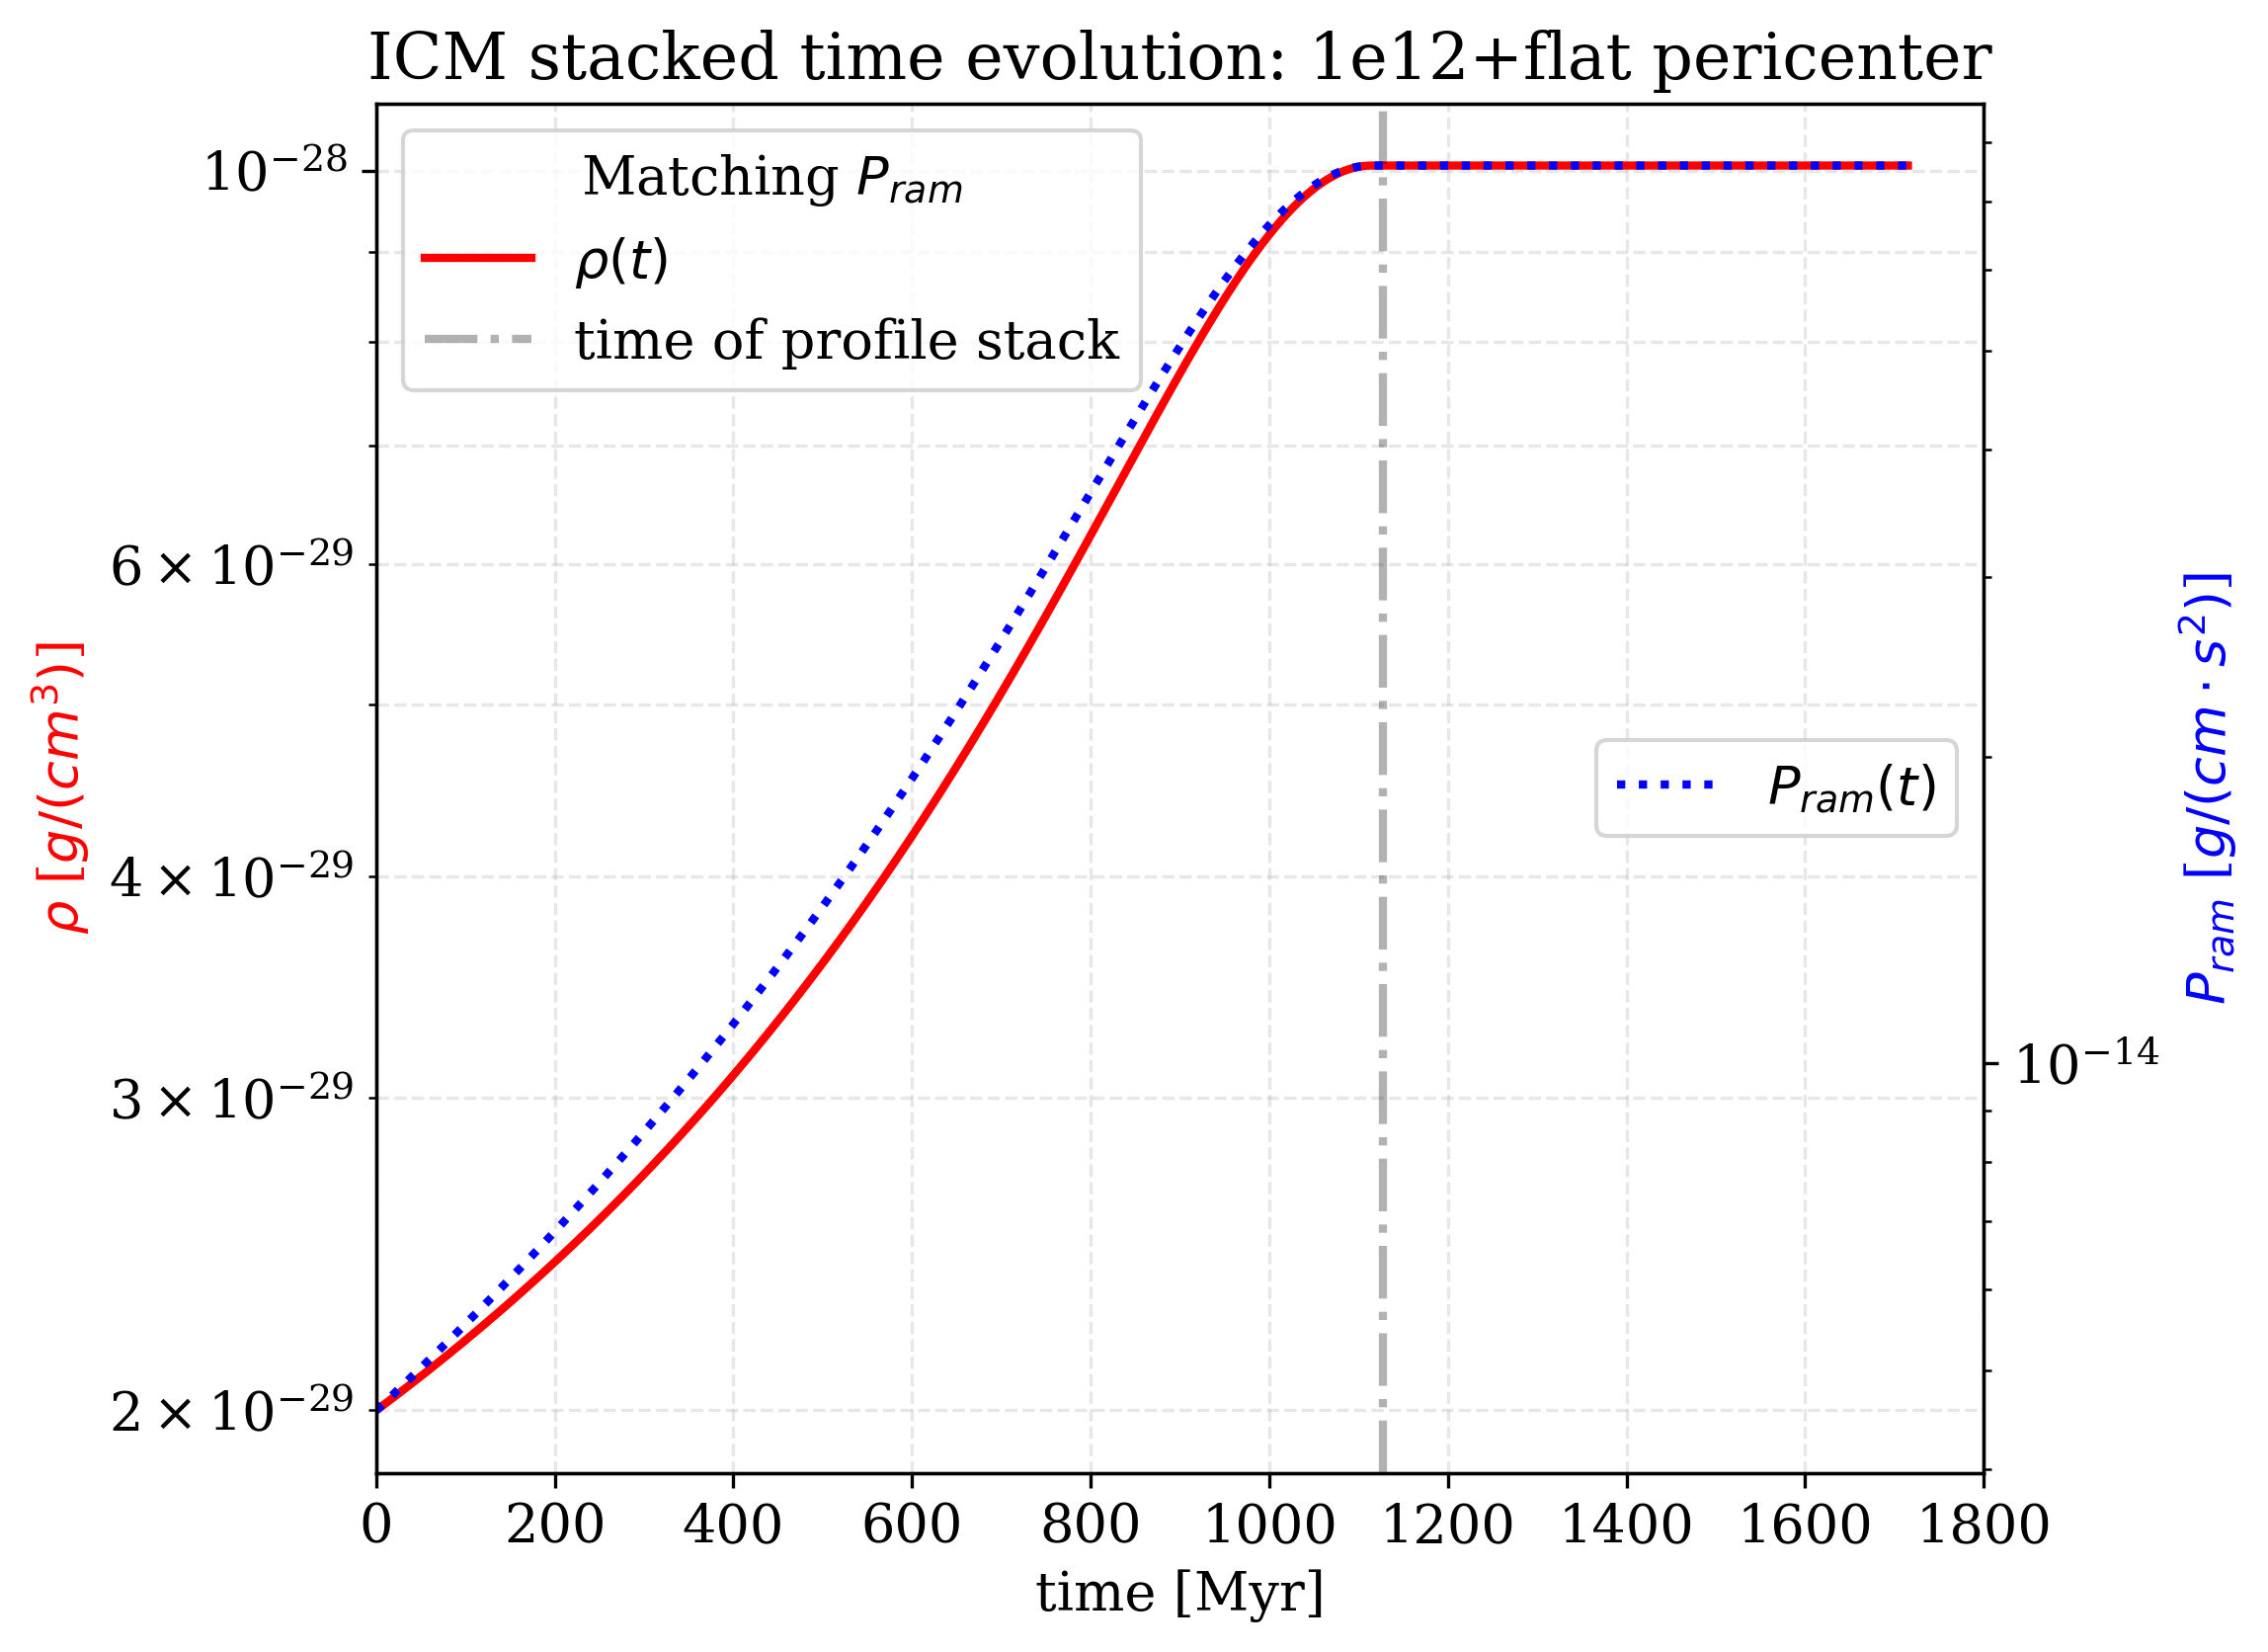

In [35]:
# sanity check 12W: Stacking pericenter condition

fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=300)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/(cm^{3})$]',color='r')

plt.title(r'ICM stacked time evolution: 1e12+flat pericenter')

plt.plot(time_ts_1e12_pericenter_full/u.Myr.to(u.s), rho_ts_1e12_pericenter_full, 'r-',lw=2,label=r'$\rho(t)$')
plt.axvline(x=1127, color='k',ls='-.',lw=2, alpha=0.3,label='time of profile stack')
plt.yscale('log')
plt.xlim(0,1800)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e12_pericenter_full/u.Myr.to(u.s), 
         rho_ts_1e12_pericenter_full*(vy_ts_1e12_pericenter_full**2 + vz_ts_1e12_pericenter_full**2), 
        'b:',lw=2,label=r'$P_{ram}(t)$')
ax2.set_yscale('log')
ax2.set_ylabel(r'$P_{ram}$ [$g/(cm \cdot s^{2})$]',color='b')
ax2.legend(loc='center right')

#plt.savefig('ICM_profile_stack_1e12_pericenter.png')
plt.show()

### Question: is it appropriate to assume v_r < 0 physically? first infall
### Question: what temperature most appropriate for a MW-like low mass halo?
---
reportedly log T = 6.1 - 6.4 from Miller and Bregman line fitting; at such low temperature, need to be careful about Mach number choices
### The MW profile is expected to be quite different from what I've worked on before: low density low temperature low velocity


In [36]:
# feedback 0125: halo not enough pressure, especially at large radius
# this is reflected in simulations (currently wo cooling)
# idea 1. update to Miller and Bregman 2015 new model?

# Voit 2019 various fitting
# cf Mary's suggestion 0204, look at absorption lines too?

## 3.2 The more massive halos -- $10^{13}$ and $10^{14}$ cases
---
Potential discrepancies in NFW definition: Komatsu and Seljak defines $M_{vir} \equiv M_{100}$ and concentration from Seljak (2000), see their eqn (12); while I initially used $M_{vir} \equiv M_{200}$ and concentration from the $m-c-z$ (Ludlow et al 2014) paper to define my NFW dark matter models.

### 3.2.1. ICM Temperatures $T_{X}$
---
Can be obtained (given $M_{500}$) from, e.g., Figure 17 of Komatsu and Seljak, adopting $\alpha=1$ for an NFW model. 

$10^{13}$ $M_{\odot}$ case is off the grid...

Now, cf Komatsu and Seljak equation (39):
\begin{equation}
    k_{B} T_{X} = \eta_{X} \frac{G \mu m_{p} M_{vir}}{3 r_{vir}}
\end{equation}

In [37]:
# obtain surface temperature estimates from equation (39) of K&S

eta_x = np.array([2.9, 2.35, 1.85])
kT = (eta_x *G*mean_molecular_mass*mu * M_host_halos.cgs/(3*Rvir_host_halos*u.kpc).cgs).value * u.erg.to(u.keV)
surf_temp = (eta_x *G*mean_molecular_mass*mu * M_host_halos.cgs/(3*Rvir_host_halos*u.kpc).cgs/kB).value
print ('surface temperature in units of keV =',kT)
print ('surface temperature in units of 1e6 Kelvin =',surf_temp/1e6)

surface temperature in units of keV = [0.12661034 0.47621791 1.74010821]
surface temperature in units of 1e6 Kelvin = [ 1.46925204  5.52627934 20.19311721]


In [38]:
surf_temp[1]

5526279.335788472

### 3.2.2 Obtaining Gas Density Profile Paramters $\beta$ and $r_{core}$ from $T_{X}$

In [39]:
r500_host_halos/r100_host_halos

array([0.58480355, 0.58480355, 0.58480355])

In [40]:
rmax_r500_1e13 = 0.48 # from figure 11, using kT = 0.476 keV
rmax_r500_1e14 = 0.62 # from figure 11, using kT = 1. keV
print ('rmax over rvir for 1e13 halo =',rmax_r500_1e13*r500_host_halos[1]/r100_host_halos[1],'\n',
       'rmax over rvir for 1e14 halo =',rmax_r500_1e14*r500_host_halos[2]/r100_host_halos[2])

rmax over rvir for 1e13 halo = 0.2807057028684352 
 rmax over rvir for 1e14 halo = 0.3625781995383954


In [41]:
# reading from Komatsu and Seljac figure 10 via rmax/rvir values above
# logic chain: following temperature --> rmax over r_vir --> reasonable betas and r_cores

# deal with the hubble constant scaling factor here
little_h = 0.67

beta_1e13 = 0.655
beta_1e14 = 0.675

r_core_1e13 = 17/little_h
r_core_1e14 = 51/little_h
print ('X-ray core radii of the 1e13, 1e14 halos [kpc] =', r_core_1e13, r_core_1e14)

X-ray core radii of the 1e13, 1e14 halos [kpc] = 25.37313432835821 76.11940298507463


### 3.2.3 Analytic Pipiline: From $M_{500,DM}$ to $\rho_{0,gas}$ (As an Integration Constant)
---
\begin{equation}
    M_{500,gas} \approx 0.1 \cdot M_{500,DM} = \int_{0}^{r_{500}} 4 \pi r^{2} \rho_{gas}(r) dr,
\end{equation}
while we continue to assume a $\beta$-model isothermal density profile:
\begin{equation}
    \rho_{gas}(r) = \rho_{gas,0} \cdot [1+(\frac{r}{r_{c}})^{2}]^{-3 \beta/2}
\end{equation}

Obtaining $r_{core}$ and $\beta$ from X-ray observational results, $M_{500,DM}$ from the NFW model, and solve for the integration constant $\rho_{gas,0}$. In this way, we obtain $\rho_{gas}(r)$ for such halos.

For our purpose, we can rewrite the above equations as: 
\begin{equation}
    M_{500,gas} \approx 0.1 \cdot M_{500,DM} = 4 \pi \rho_{gas,0} \int_{0}^{r_{500}} [1+(\frac{r}{r_{c}})^{2}]^{-3 \beta/2} r^{2}  dr,
\end{equation}

Calculate the radius integration on the right hand side, we are able to solve for the unknown $\rho_{gas,0}$ then.

In [42]:
# obtain rho_0 via numerically integrating M_gas profile to match 10% M_500,DM

# function below is the radius dependent part of the beta profile, the integrand
def rho_over_rho0_beta_profile(r, r_xray_core, beta): 
    integrand = r**2 * (1. + (r/r_xray_core)**2)**(-1.5*beta)
    return integrand

# 1e13 case
r_xray_core = r_core_1e13*u.kpc.to(u.cm)
beta = beta_1e13

mass_integral_1e13 = quad(rho_over_rho0_beta_profile, 
                          0, r500_host_halos[1]*u.kpc.to(u.cm),
                          args=(r_xray_core, beta))[0]

rho_0_gas_1e13 = 0.1*m500_1e13.cgs/(4*np.pi*mass_integral_1e13)
print ('central number density 1e13 halo =',rho_0_gas_1e13/mu,
      'central mass density 1e13 halo =',rho_0_gas_1e13)

# 1e14 case
r_xray_core = r_core_1e14*u.kpc.to(u.cm)
beta = beta_1e14

mass_integral_1e14 = quad(rho_over_rho0_beta_profile, 
                          0, r500_host_halos[2]*u.kpc.to(u.cm),
                          args=(r_xray_core, beta))[0]

rho_0_gas_1e14 = 0.1*m500_1e14.cgs/(4*np.pi*mass_integral_1e14)
print ('central number density 1e14 halo =',rho_0_gas_1e14/mu,
      'central mass density 1e14 halo =',rho_0_gas_1e14)

central number density 1e13 halo = 0.012938966795155164 central mass density 1e13 halo = 2.148565984479535e-26 g
central number density 1e14 halo = 0.007644901597387047 central mass density 1e14 halo = 1.2694657762773937e-26 g


In [43]:
mass_r_MB15_cgs*ne_factor

<Quantity [6.12586340e-23, 6.02087763e-23, 5.91769112e-23, 5.81627304e-23,
           5.71659307e-23, 5.61862142e-23, 5.52232883e-23, 5.42768651e-23,
           5.33466618e-23, 5.24324004e-23, 5.15338078e-23, 5.06506153e-23,
           4.97825591e-23, 4.89293798e-23, 4.80908223e-23, 4.72666361e-23,
           4.64565750e-23, 4.56603967e-23, 4.48778635e-23, 4.41087414e-23,
           4.33528006e-23, 4.26098152e-23, 4.18795632e-23, 4.11618263e-23,
           4.04563901e-23, 3.97630437e-23, 3.90815800e-23, 3.84117953e-23,
           3.77534894e-23, 3.71064657e-23, 3.64705307e-23, 3.58454945e-23,
           3.52311702e-23, 3.46273742e-23, 3.40339262e-23, 3.34506488e-23,
           3.28773676e-23, 3.23139114e-23, 3.17601118e-23, 3.12158033e-23,
           3.06808232e-23, 3.01550116e-23, 2.96382115e-23, 2.91302683e-23,
           2.86310304e-23, 2.81403484e-23, 2.76580758e-23, 2.71840685e-23,
           2.67181847e-23, 2.62602853e-23, 2.58102335e-23, 2.53678946e-23,
           2.49331367e-23

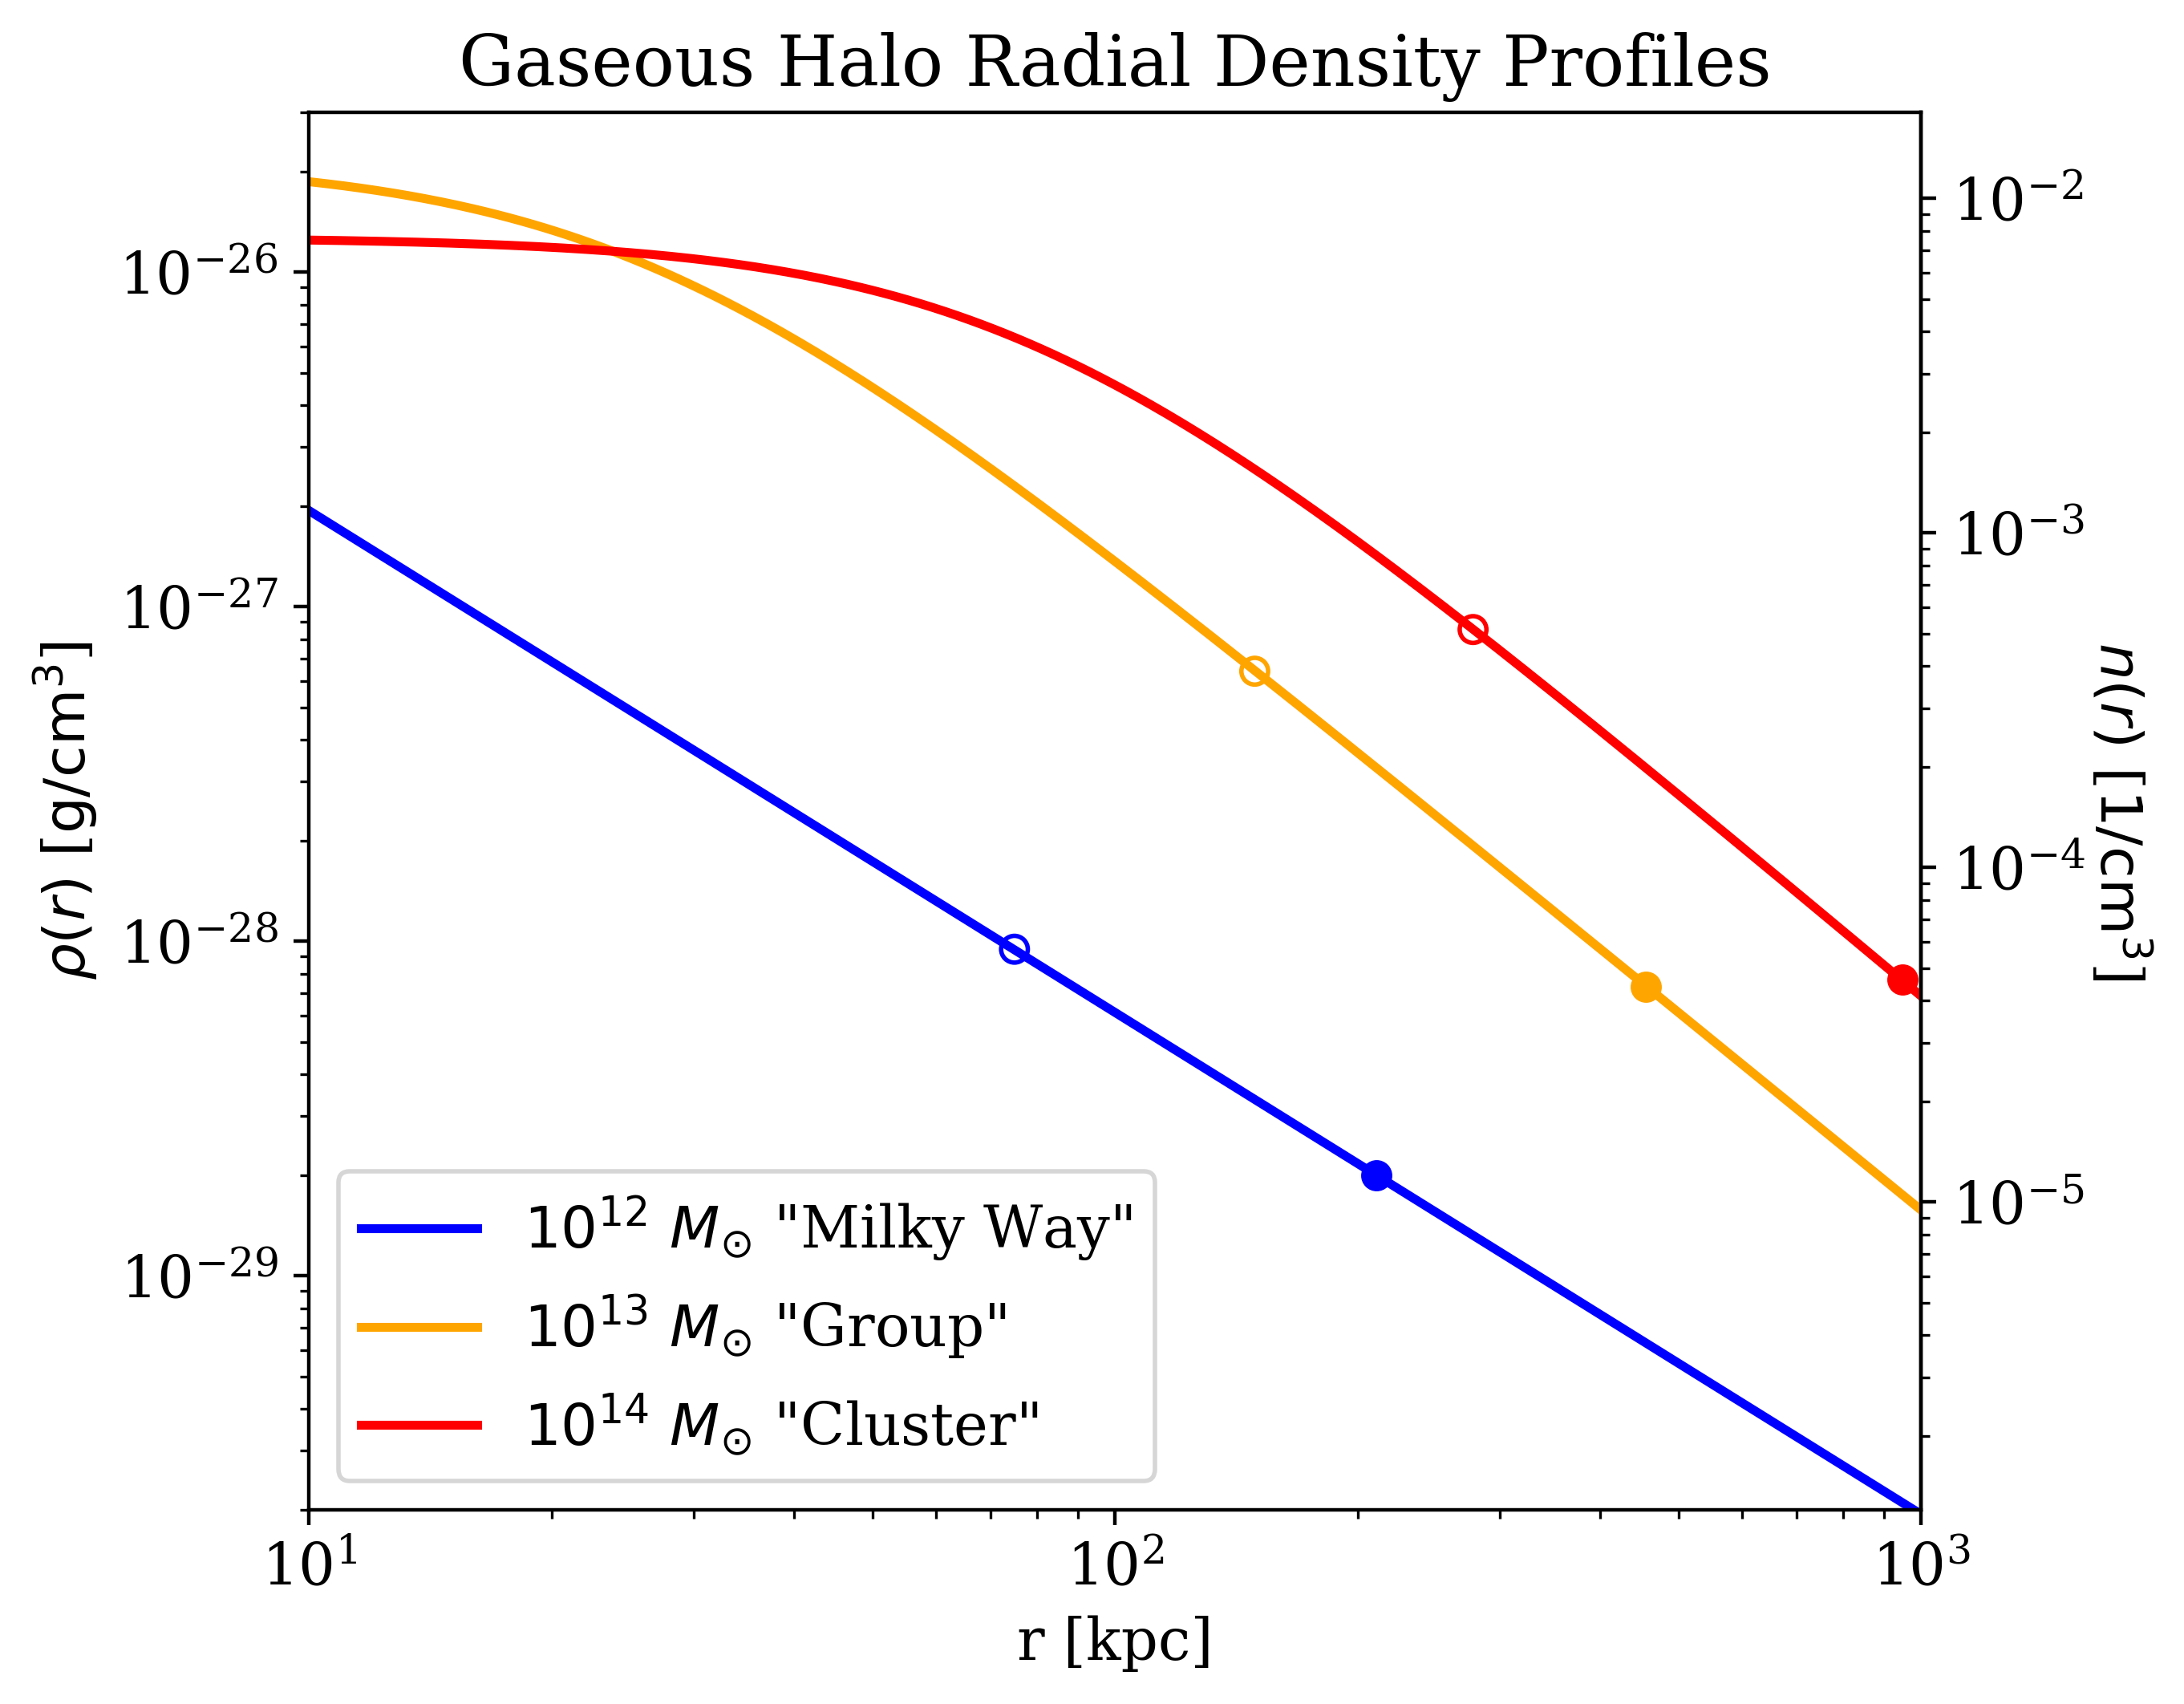

In [44]:
# visualize the density profiles
rho_r_1e13 = rho_0_gas_1e13 * (1. + (r.value/r_core_1e13)**2) ** (-3.*beta_1e13/2.)
rho_r_1e14 = rho_0_gas_1e14 * (1. + (r.value/r_core_1e14)**2) ** (-3.*beta_1e14/2.)

fig,ax = plt.subplots(1, 1, figsize=(7,5.5),dpi=400)
plt.rc('font', size=13)
#plt.grid(True, alpha=0.5, which='major', axis='y',ls='dotted')
plt.title('Gaseous Halo Radial Density Profiles')

plt.plot(r.value, mass_r_MB15_cgs*ne_factor,'b-',lw=2,
        label=r'$10^{12}$ $M_{\odot}$ "Milky Way"')

Rvir_12W_index = np.argmin(abs(r.value-211))
Rperi_12W_index= np.argmin(abs(r.value-75))
plt.scatter(211, mass_r_MB15_cgs[Rvir_12W_index]*ne_factor, marker='o', color='b')
plt.scatter(75,  mass_r_MB15_cgs[Rperi_12W_index]*ne_factor, marker='o', color='b',facecolor='none')

plt.plot(r.value, rho_r_1e13, color='orange',ls='-',lw=2,
         #label=r'$10^{13}$ $M_{\odot}$: $r_{c}^{X}=25$ kpc, $R_{200}=455$ kpc, $\beta=0.655$')
         label=r'$10^{13}$ $M_{\odot}$ "Group"')


Rvir_13W_index = np.argmin(abs(r.value-455))
Rperi_13W_index= np.argmin(abs(r.value-149))
plt.scatter(455, rho_r_1e13[Rvir_13W_index], marker='o', color='orange')
plt.scatter(149, rho_r_1e13[Rperi_13W_index], marker='o', color='orange',facecolor='none')


plt.plot(r.value, rho_r_1e14, 'r-',lw=2,
         #label=r'$10^{14}$ $M_{\odot}$: $r_{c}^{X}=76$ kpc, $R_{200}=979$ kpc, $\beta=0.675$')
         label=r'$10^{14}$ $M_{\odot}$ "Cluster"')

Rvir_14W_index = np.argmin(abs(r.value-949))
Rperi_14W_index= np.argmin(abs(r.value-278))
plt.scatter(949, rho_r_1e14[Rvir_14W_index], marker='o', color='r')
plt.scatter(278, rho_r_1e14[Rperi_14W_index], marker='o', color='r',facecolor='none')


#plt.loglog()
plt.xscale('log')
plt.yscale('log')
#plt.tick_params(labelright=True)
plt.xlim(10,1000)
plt.ylim(2e-30,3e-26)
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel(r'$\rho(r)$ [$\rm g/cm^{3}$]')

def mass_to_num(mass_dens):
    return mass_dens/mu.value

def num_to_mass(num_dens):
    return num_dens*mu.value

secax = ax.secondary_yaxis('right', functions=(mass_to_num, num_to_mass))
secax.set_ylabel(r'$n(r)$ [$1/\rm cm^{3}$]',rotation=270,labelpad=15)


plt.tight_layout()
#plt.savefig(plt_dir+'host_density_profiles.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

### 3.2.4 (Putting it all together) Combining $\rho(r)$ profile and $r(t)$ time series to obtain $\rho(t)$

In [45]:
# obtain density from radius

def mass_density_group_halo(r_kpc): # 1e13
    return rho_0_gas_1e13 * (1. + (r_kpc/r_core_1e13)**2)**(-1.5*beta_1e13)

def mass_density_cluster_halo(r_kpc): # 1e14
    return rho_0_gas_1e14 * (1. + (r_kpc/r_core_1e14)**2)**(-1.5*beta_1e14)

In [46]:
# orbital radii time series
#orbit_1e13_r = np.sqrt(orbit_1e13.pos.x**2 + orbit_1e13.pos.y**2)
#orbit_1e14_r = np.sqrt(orbit_1e14.pos.x**2 + orbit_1e14.pos.y**2)

# density time series from positional time series, index of 1100 (1100 Myr) is roughly the time of first infall
rho_ts_1e12 = mass_density_beta_profile_MB15(orbit_1e12_r[:first_infall_ind_1e12+1].value) * ne_factor.value
rho_ts_1e13 = (mass_density_group_halo(orbit_1e13_r[:first_infall_ind_1e13+1].value)).value
rho_ts_1e14 = (mass_density_cluster_halo(orbit_1e14_r[:first_infall_ind_1e14+1].value)).value

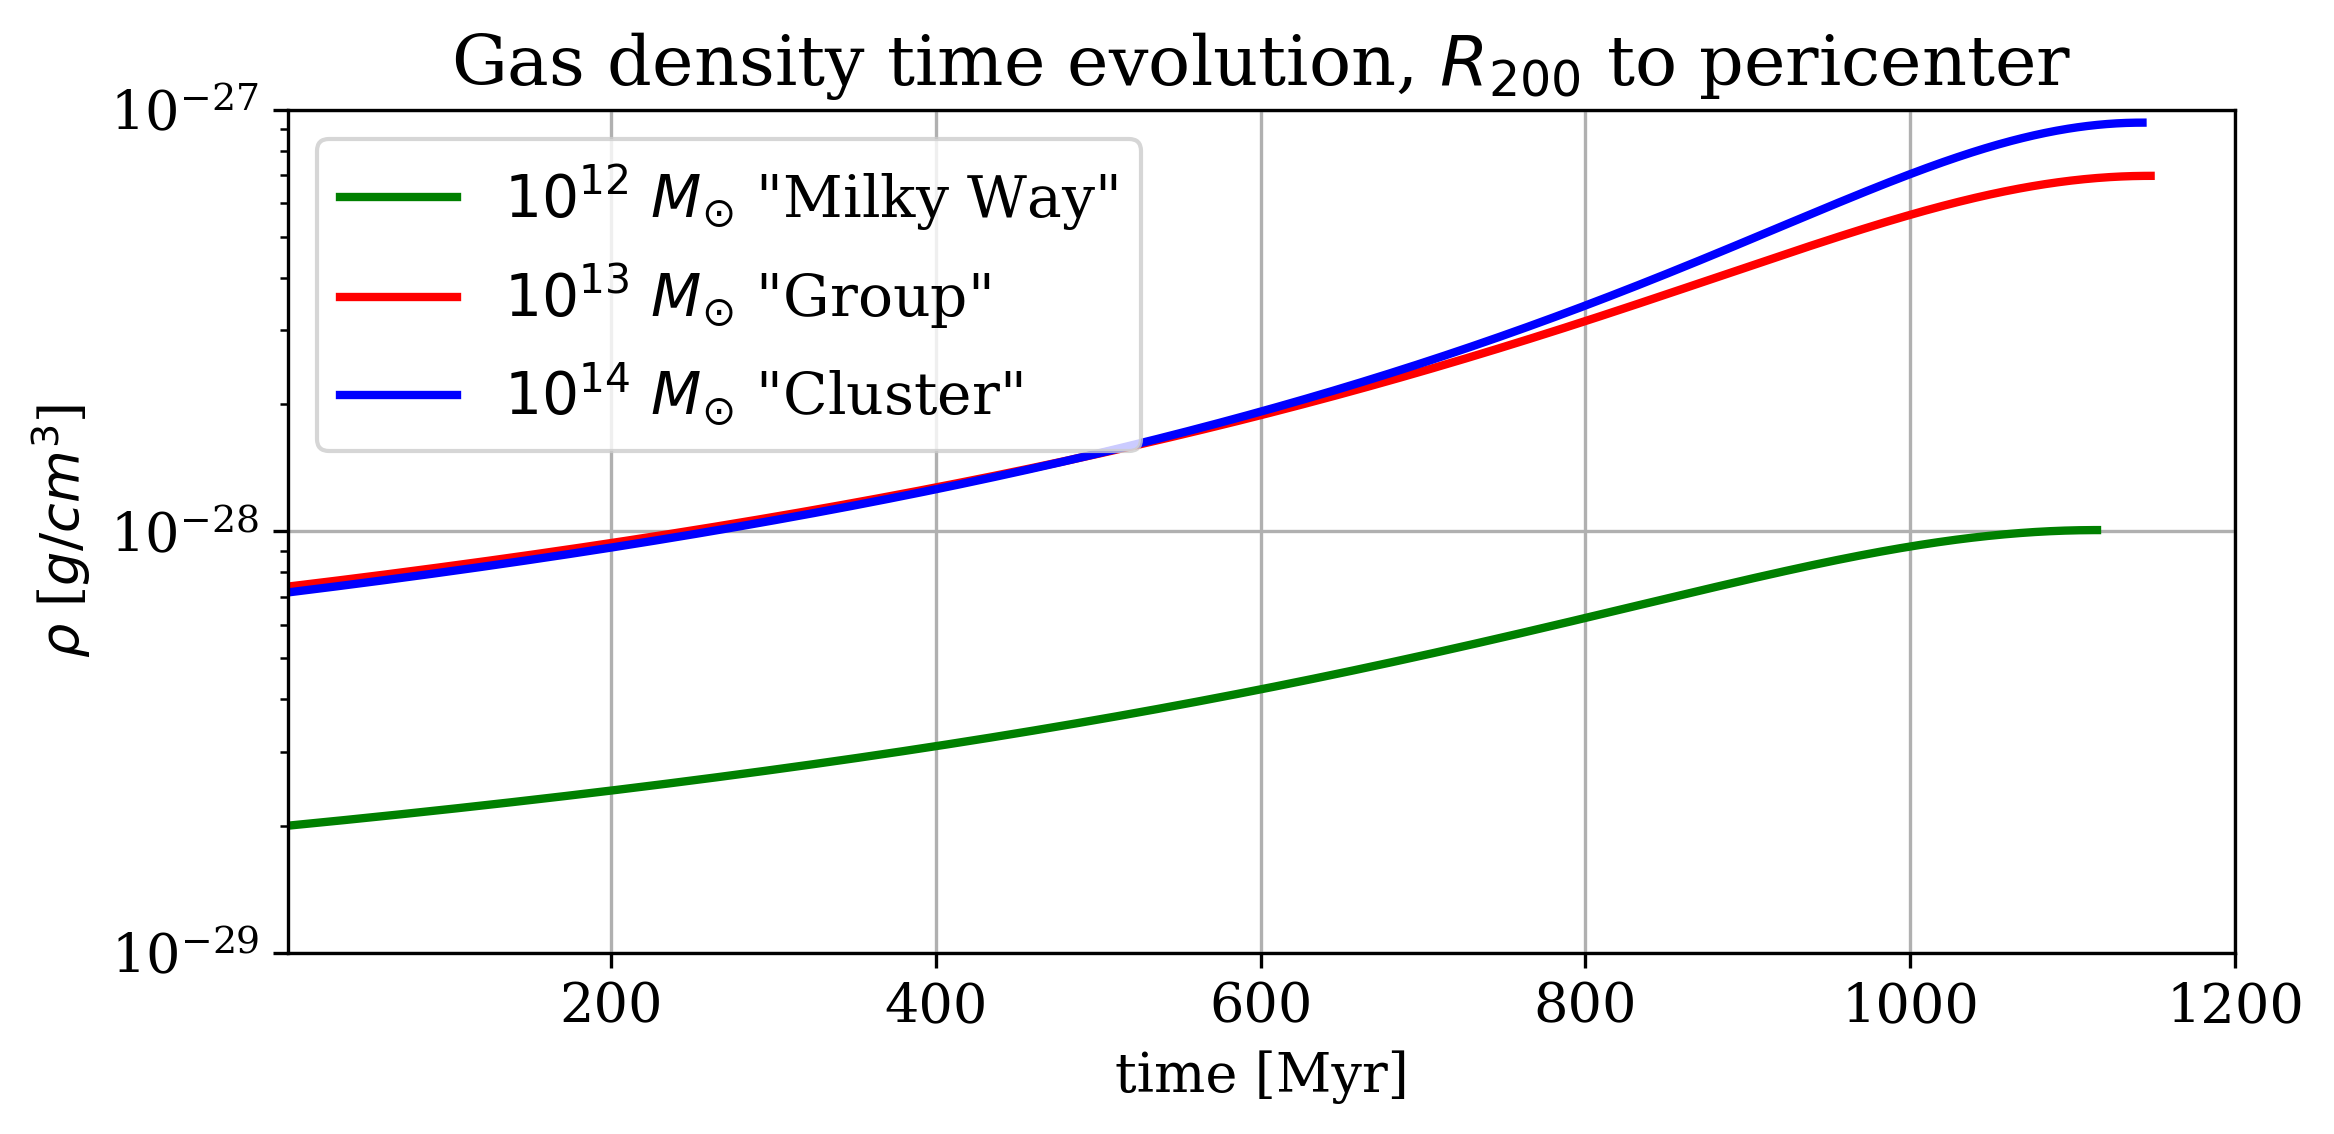

In [47]:
# visualize the density time series

fig,ax = plt.subplots(1, 1, figsize=(8,4),dpi=300)
plt.rc('font', size=14)
plt.grid(True)
plt.title(r'Gas density time evolution, $R_{200}$ to pericenter')
plt.plot(orbit_1e12.t[:first_infall_ind_1e12+1], rho_ts_1e12, 'g-',lw=2,
         label=r'$10^{12}$ $M_{\odot}$ "Milky Way"')
plt.plot(orbit_1e13.t[:first_infall_ind_1e13+1], rho_ts_1e13, 'r-',lw=2,
         label=r'$10^{13}$ $M_{\odot}$ "Group"')
plt.plot(orbit_1e14.t[:first_infall_ind_1e14+1], rho_ts_1e14,'b-',lw=2,
         label=r'$10^{14}$ $M_{\odot}$ "Cluster"')

plt.yscale('log')
#plt.tick_params(labelright=True)
#plt.hlines(y=rho_ts_1e13[0], xmin=1, xmax=1200, color='k',ls='-.',label=r'$\rho_{13}$ at $t=0$')
#plt.hlines(y=rho_ts_1e12[1060], xmin=1, xmax=1200, color='k',ls='--',
#           label=r'$\rho_{12}$ where $P_{ram12}=P_{ram13}$')
plt.xlim(1,1200)
plt.ylim(1e-29,1e-27)
plt.legend()
plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/cm^{3}$]')
plt.tight_layout()
#plt.savefig('all_halos_orbital_density_evolution.png')
plt.show()

In [48]:
# update 0508/2022: experimenting 'tagged' wind profiles
# where does 1e12 and 1e13 densities match?

orbit_1e12.t[np.argmin(abs(rho_ts_1e12 - rho_ts_1e13[0]))]

<Quantity 881. Myr>

## 4. Generating ram pressure time series and ICM inflow files

In [49]:
Pram_ts_1e12 = (rho_ts_1e12 * (vel_1e12[:first_infall_ind_1e12+1]*1e5)**2)
Pram_ts_1e13 = (rho_ts_1e13 * (vel_1e13[:first_infall_ind_1e13+1]*1e5)**2)
Pram_ts_1e14 = (rho_ts_1e14 * (vel_1e14[:first_infall_ind_1e14+1]*1e5)**2)

print (Pram_ts_1e12,'\n',
       Pram_ts_1e13,'\n',
       Pram_ts_1e14)

[4.56753776e-15 4.57618354e-15 4.58485109e-15 ... 7.59717263e-14
 7.59740437e-14 7.59747135e-14] 
 [6.85401935e-14 6.86893960e-14 6.88390190e-14 ... 2.42780100e-12
 2.42788226e-12 2.42788990e-12] 
 [2.80195660e-13 2.80841581e-13 2.81489395e-13 ... 1.56573504e-11
 1.56581420e-11 1.56582590e-11]


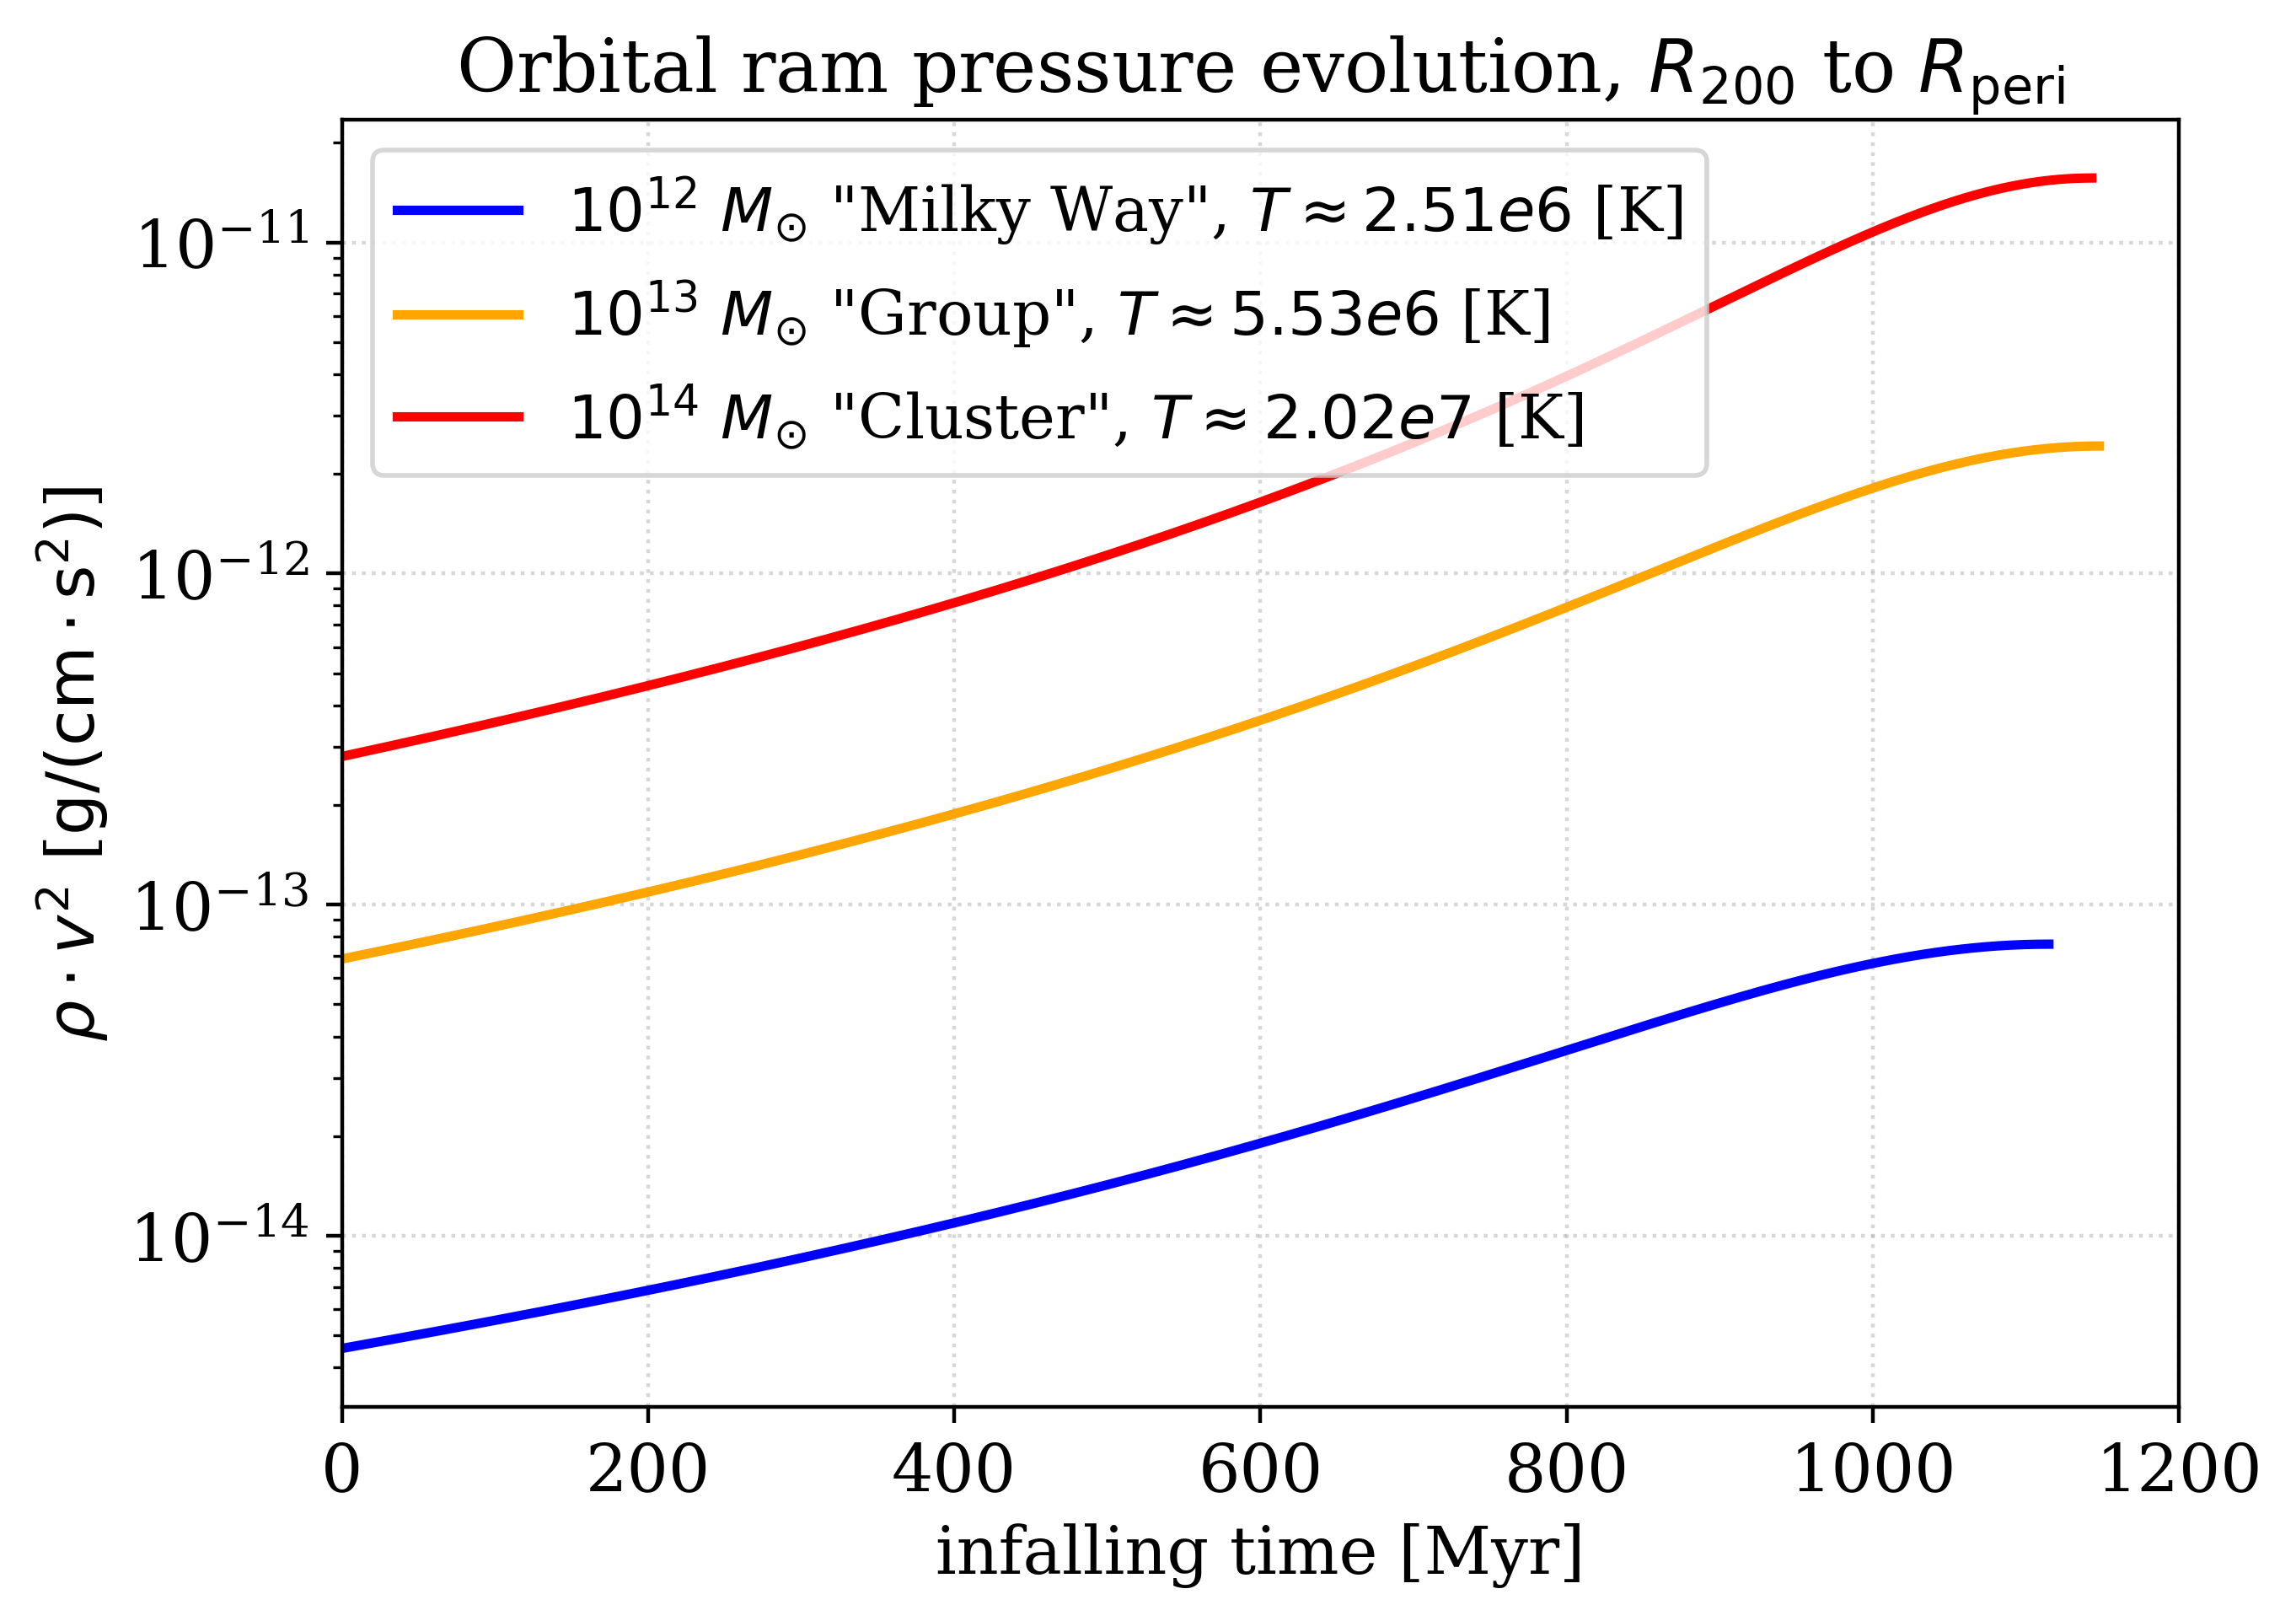

In [50]:
# visualize the ram pressure time series

fig,ax = plt.subplots(1, 1, figsize=(7,5),dpi=400)
plt.rc('font', size=13)
plt.grid(True, which='major', alpha=0.5, ls='dotted')

plt.title(r'Orbital ram pressure evolution, $R_{200}$ to $R_{\rm peri}$')
'''
plt.plot(orbit_1e12.t[:first_infall_ind_1e12+1],
         rho_ts_1e12 * (vel_1e12[:first_infall_ind_1e12+1]*1e5)**2, 'g-',lw=2,
         label=r'$10^{12}$ $M_{\odot}$ "Milky Way", $T \approx 2.51e6$ [K]')
plt.plot(orbit_1e13.t[:first_infall_ind_1e13+1], 
         rho_ts_1e13 * (vel_1e13[:first_infall_ind_1e13+1]*1e5)**2, 'r-',lw=2,
         label=r'$10^{13}$ $M_{\odot}$ "Group", $T_{X} \approx 5.53e6$ [K]')
plt.plot(orbit_1e14.t[:first_infall_ind_1e14+1], 
         rho_ts_1e14 * (vel_1e14[:first_infall_ind_1e14+1]*1e5)**2,'b-',lw=2,
         label=r'$10^{14}$ $M_{\odot}$ "Cluster", $T_{X} \approx 2.02e7$ [K]')
'''
plt.plot(orbit_1e12.t[:first_infall_ind_1e12+1],
         Pram_ts_1e12, 'b-',lw=2,
         label=r'$10^{12}$ $M_{\odot}$ "Milky Way", $T \approx 2.51e6$ [K]')
plt.plot(orbit_1e13.t[:first_infall_ind_1e13+1], 
         Pram_ts_1e13, color='orange', ls='-', lw=2,
         label=r'$10^{13}$ $M_{\odot}$ "Group", $T \approx 5.53e6$ [K]')
plt.plot(orbit_1e14.t[:first_infall_ind_1e14+1], 
         Pram_ts_1e14,'r-',lw=2,
         label=r'$10^{14}$ $M_{\odot}$ "Cluster", $T \approx 2.02e7$ [K]')

# update 0509 for tagging profiles
#plt.hlines(y=Pram_ts_1e13[0],xmin=1, xmax=1200, color='k',ls='--',label=r'$P_{ram13}$ at $t=0$')
#plt.hlines(y=Pram_ts_1e12[870],xmin=1, xmax=1200, color='k',ls='-.',
#           label=r'$P_{ram12}$ where $\rho_{12}=\rho_{13}$')
plt.yscale('log')
#plt.tick_params(labelright=True)
plt.xlim(0,1200)

plt.legend()
plt.xlabel('infalling time [Myr]')
plt.ylabel(r'$\rho \cdot v^{2}$ [$\rm g/(cm \cdot s^{2})$]')
plt.tight_layout()
#plt.savefig(plt_dir+'all_halos_orbital_ram_pressure_evolution.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [51]:
# update 0508/2022: experimenting 'tagged' wind profiles
# where does 1e12 and 1e13 ram pressures match?
# update 0528/2022: now matching the 1e13 and 1e14 cases

ind_match_Pram_12_13 = np.argmin(abs(Pram_ts_1e12 - Pram_ts_1e13[0]))
print (orbit_1e12.t[ind_match_Pram_12_13])
print ('Density difference at ram pressure matching point = \n',
       rho_ts_1e12[ind_match_Pram_12_13],
       rho_ts_1e13[0])

# match Pram group and cluster cases

ind_match_Pram_13_14 = np.argmin(abs(Pram_ts_1e13 - Pram_ts_1e14[0]))
print (orbit_1e13.t[ind_match_Pram_13_14])
print ('Density difference at ram pressure matching point = \n',
       rho_ts_1e13[ind_match_Pram_13_14], rho_ts_1e14[0])

1015.0 Myr
Density difference at ram pressure matching point = 
 9.394168659919987e-29 7.381915552532524e-29
527.0 Myr
Density difference at ram pressure matching point = 
 1.6125082003957012e-28 7.149826597874586e-29


## below: output to ICMinflow file for wind tunnel simulations

In [52]:
# generate inflow profile
# update 05/08/2022: replace the somewhat arbitrary 1 Gyr (1001) selection to the first infall orbit selection

time_ts_1e13 = orbit_1e13.t[:(first_infall_ind_1e13+1)].cgs.value
rho_ts_1e13  = mass_density_group_halo(orbit_1e13_r[:(first_infall_ind_1e13+1)].value).value

# 45 degree wind
vx_ts_1e13   = np.zeros(len(time_ts_1e13))
vy_ts_1e13   = vel_1e13[:(first_infall_ind_1e13+1)] *1e5/np.sqrt(2.) #km/s -->cm/s
vz_ts_1e13   = vel_1e13[:(first_infall_ind_1e13+1)] *1e5/np.sqrt(2.) #km/s -->cm/s

temp_ts_1e13 = np.ones(len(time_ts_1e13))*surf_temp[1] # in K

# write to a data file
'''
np.savetxt('ICMinflow_1e13_group_profile_45degree_wind_first_infall_data.in', 
          np.column_stack([time_ts_1e13, rho_ts_1e13, temp_ts_1e13, vx_ts_1e13, vy_ts_1e13, vz_ts_1e13]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_1e13_group_profile_45degree_wind_first_infall_data.in\', \n          np.column_stack([time_ts_1e13, rho_ts_1e13, temp_ts_1e13, vx_ts_1e13, vy_ts_1e13, vz_ts_1e13]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

In [53]:
# generate inflow profile
# update 05/08/2022: replace the somewhat arbitrary 1 Gyr (1001) selection to the first infall orbit selection

time_ts_1e14 = orbit_1e14.t[:(first_infall_ind_1e14+1)].cgs.value
rho_ts_1e14  = mass_density_cluster_halo(orbit_1e14_r[:(first_infall_ind_1e14+1)].value).value

# 45 degree wind
vx_ts_1e14   = np.zeros(len(time_ts_1e14))
vy_ts_1e14   = vel_1e14[:(first_infall_ind_1e14+1)] *1e5/np.sqrt(2.) #km/s -->cm/s
vz_ts_1e14   = vel_1e14[:(first_infall_ind_1e14+1)] *1e5/np.sqrt(2.) #km/s -->cm/s

temp_ts_1e14 = np.ones(len(time_ts_1e14))*surf_temp[2] # in K


# write to a data file
'''
np.savetxt('ICMinflow_1e14_cluster_profile_45degree_wind_first_infall_data.in', 
          np.column_stack([time_ts_1e14, rho_ts_1e14, temp_ts_1e14, vx_ts_1e14, vy_ts_1e14, vz_ts_1e14]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_1e14_cluster_profile_45degree_wind_first_infall_data.in\', \n          np.column_stack([time_ts_1e14, rho_ts_1e14, temp_ts_1e14, vx_ts_1e14, vy_ts_1e14, vz_ts_1e14]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

### 4.1 "Tag" ICM inflow profiles to generate smooth transitions between wind runs?

## generating the 1e13 group halo profile

In [54]:
rho_ts_1e12[600]/2./1e-27

0.021071200635308974

In [55]:
# one question/uncertainty: when to tag?
# between checkpoint 87 and 106, we have rho_12 > rho_13,t=0 and Pram_12 < Pram_13,t=0

# update 05/10: attach 13W on top of 12W, matching ram pressure
# initiate the 1e13 run by restarting at 1e12 run, attach 1e13 time steps to 1e12 ICM inflow
# will need to calculate new time steps
time_ts_1e13_attach = time_ts_1e12[ind_match_Pram_12_13] + time_ts_1e13


# create the "full_evol" arrays for the 1e12+1e13 stacked profile
time_ts_1e13_full_evol = np.hstack((time_ts_1e12[:ind_match_Pram_12_13], time_ts_1e13_attach))
rho_ts_1e13_full_evol  = np.hstack((rho_ts_1e12[:ind_match_Pram_12_13], rho_ts_1e13))

vx_ts_1e13_full_evol = np.hstack((vx_ts_1e12[:ind_match_Pram_12_13], vx_ts_1e13)) 
vy_ts_1e13_full_evol = np.hstack((vy_ts_1e12[:ind_match_Pram_12_13], vy_ts_1e13)) 
vz_ts_1e13_full_evol = np.hstack((vz_ts_1e12[:ind_match_Pram_12_13], vz_ts_1e13)) 

temp_ts_1e13_full_evol = np.hstack((temp_ts_1e12[:ind_match_Pram_12_13], temp_ts_1e13))
print (time_ts_1e12[ind_match_Pram_12_13], time_ts_1e13_full_evol/u.Myr.to(u.s))

# write to a data file
'''
np.savetxt('ICMinflow_1e13_group_profile_45degree_wind_stacked_on_1e12_data.in', 
          np.column_stack([time_ts_1e13_full_evol, rho_ts_1e13_full_evol,temp_ts_1e13_full_evol,
                           vx_ts_1e13_full_evol, vy_ts_1e13_full_evol, vz_ts_1e13_full_evol]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

3.2030964e+16 [0.000e+00 1.000e+00 2.000e+00 ... 2.161e+03 2.162e+03 2.163e+03]


'\nnp.savetxt(\'ICMinflow_1e13_group_profile_45degree_wind_stacked_on_1e12_data.in\', \n          np.column_stack([time_ts_1e13_full_evol, rho_ts_1e13_full_evol,temp_ts_1e13_full_evol,\n                           vx_ts_1e13_full_evol, vy_ts_1e13_full_evol, vz_ts_1e13_full_evol]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

In [56]:
time_ts_1e13_full_evol.shape

(2164,)

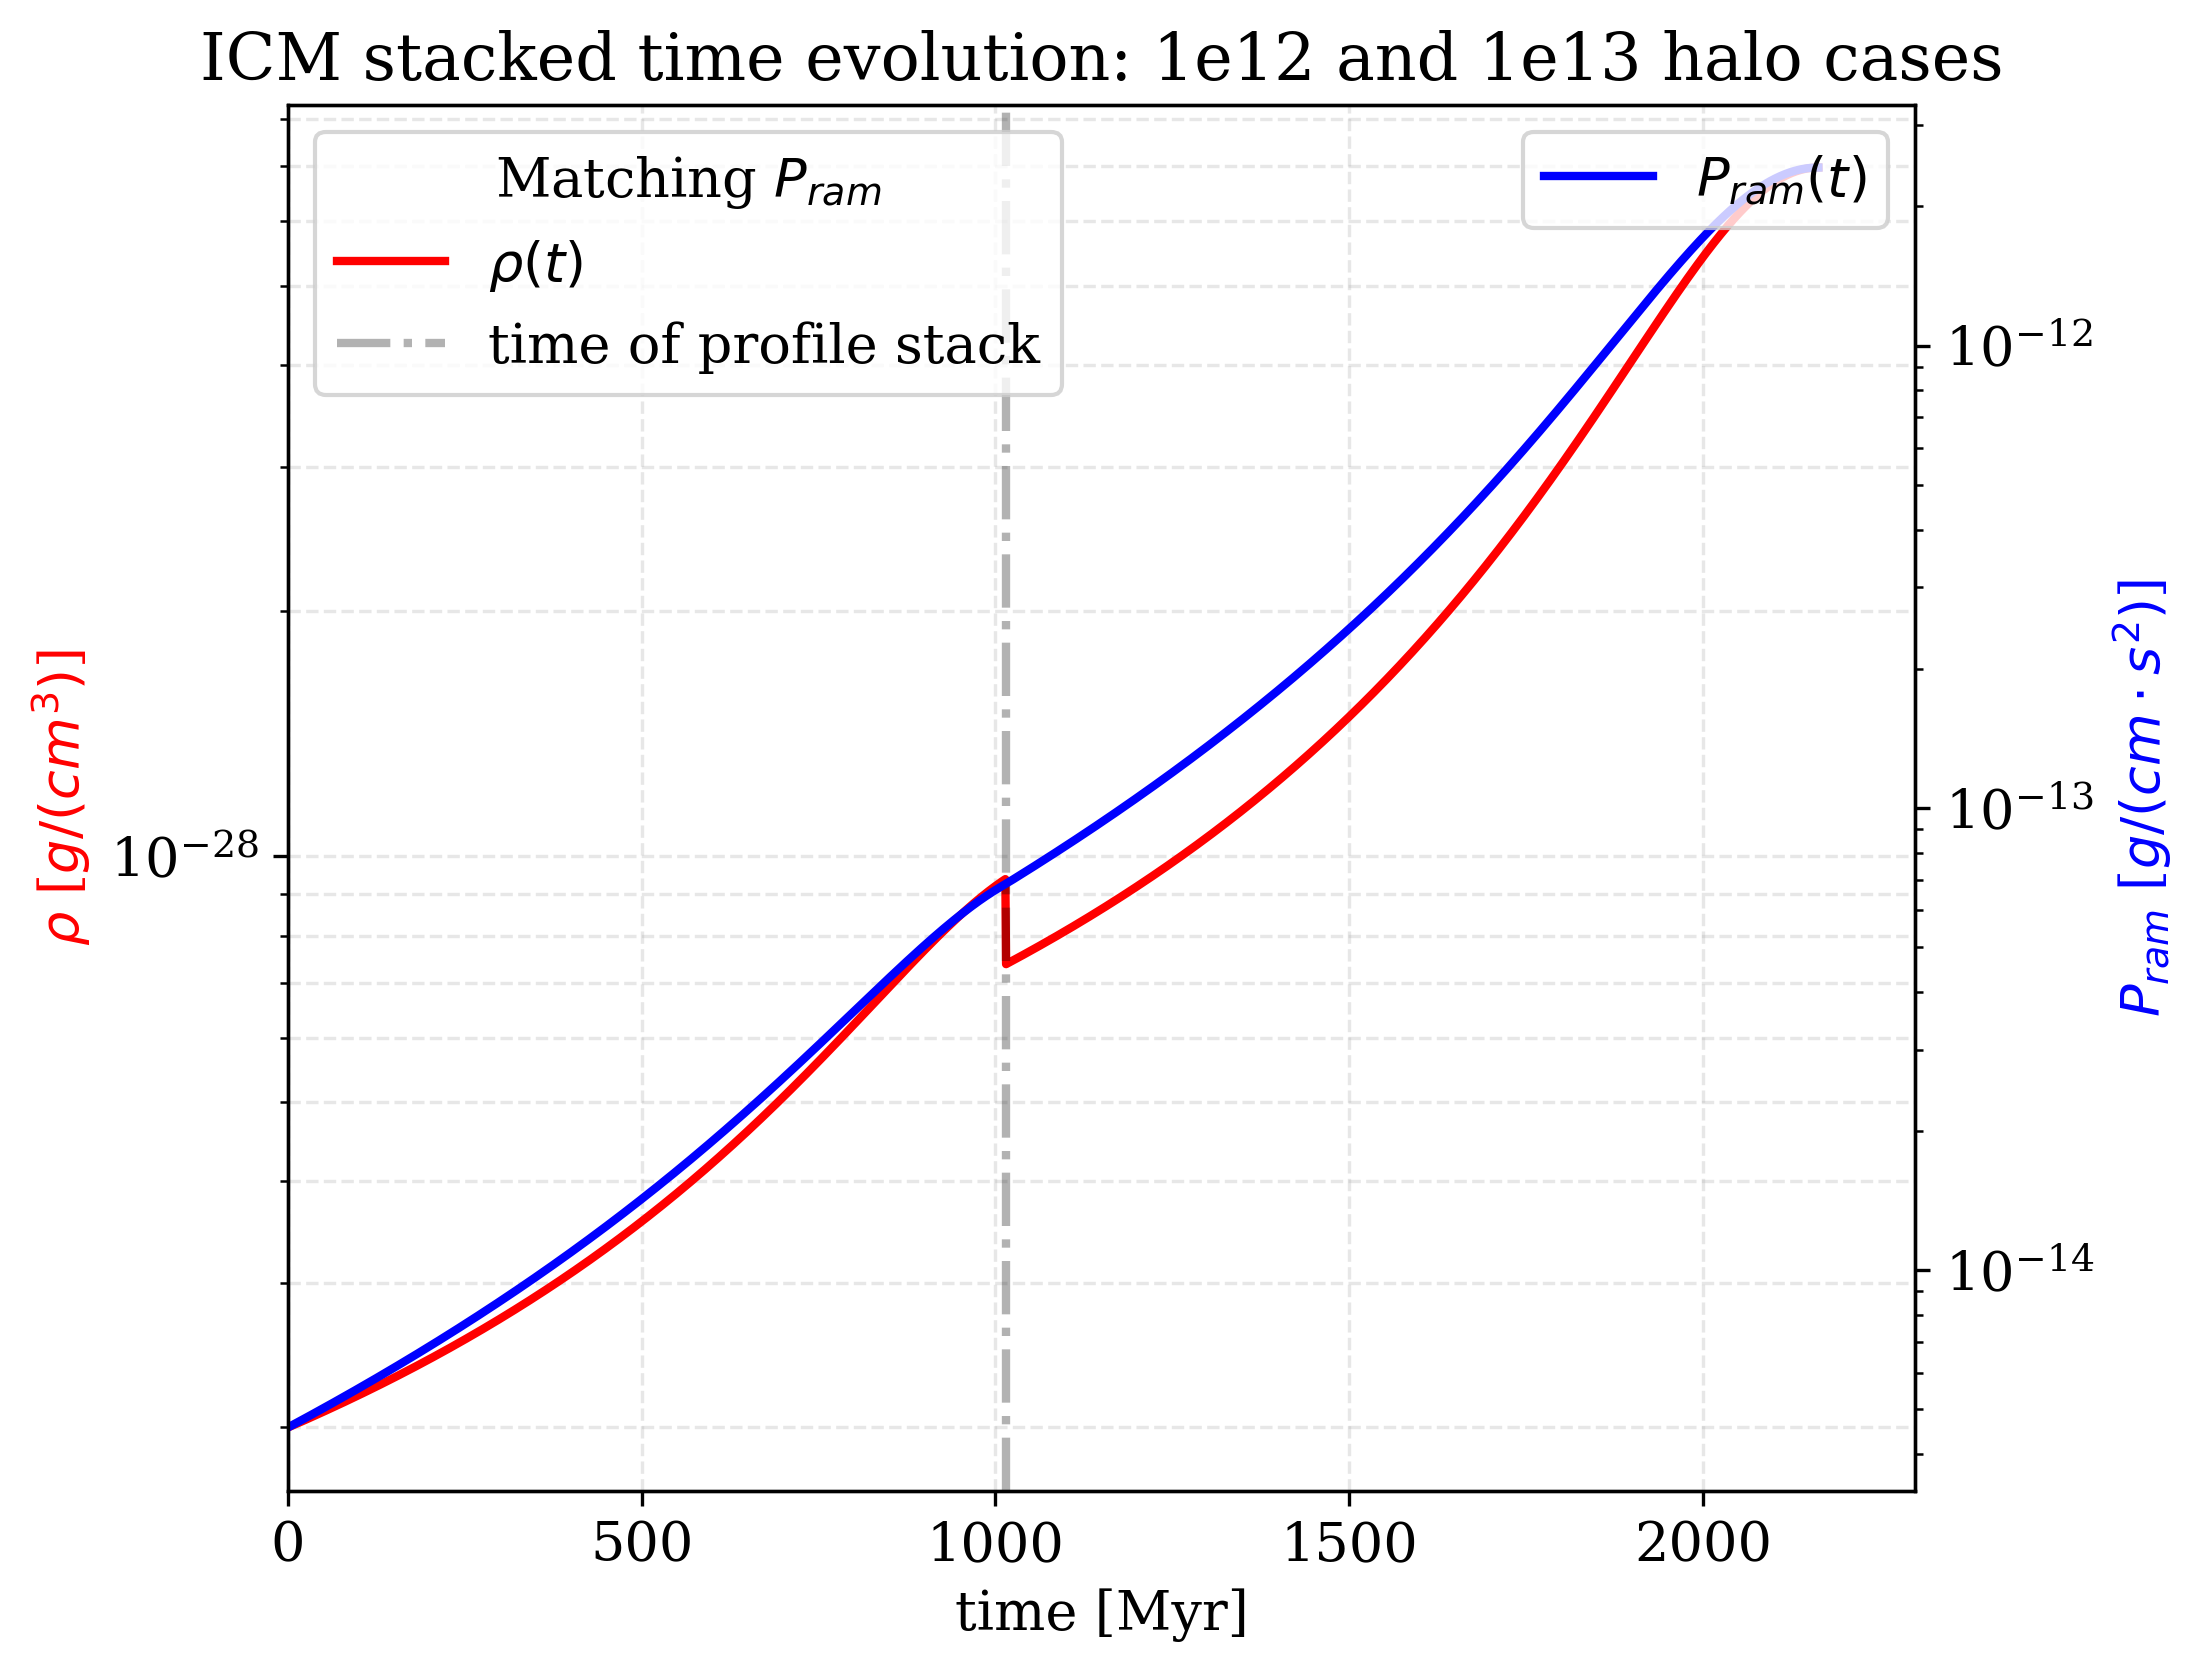

In [57]:
# the stacked time evolution

fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=300)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/(cm^{3})$]',color='r')

plt.title(r'ICM stacked time evolution: 1e12 and 1e13 halo cases')

plt.plot(time_ts_1e13_full_evol/u.Myr.to(u.s), rho_ts_1e13_full_evol, 'r-',lw=2,label=r'$\rho(t)$')
plt.axvline(x=ind_match_Pram_12_13, color='k',ls='-.',lw=2, alpha=0.3,label='time of profile stack')
plt.yscale('log')
plt.xlim(0,2300)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e13_full_evol/u.Myr.to(u.s), 
         rho_ts_1e13_full_evol*(vy_ts_1e13_full_evol**2 + vz_ts_1e13_full_evol**2), 
        'b-',lw=2,label=r'$P_{ram}(t)$')
ax2.set_yscale('log')
ax2.set_ylabel(r'$P_{ram}$ [$g/(cm \cdot s^{2})$]',color='b')
ax2.legend(loc='upper right')

#plt.savefig('ICM_profile_stack_1e12_1e13.png')
plt.show()

### update 0619: (1e13 case) attaching a constant pericenter wind until it reaches the galaxy disk

In [58]:
print ('time needed for pericenter wind to travel through (half-)simulation box: [Myr] \n',
       5.e23/2./vy_ts_1e13_full_evol[-1]/(u.Myr.to(u.s)),'\n',
      5.e23/vy_ts_1e13_full_evol[-1]/(u.Myr.to(u.s)))

print ('Conclusion: \n',
      '~20 checkpoints for wind to reach half box \n',
      '~40 checkpoints for full box')

time needed for pericenter wind to travel through (half-)simulation box: [Myr] 
 189.91992950383505 
 379.8398590076701
Conclusion: 
 ~20 checkpoints for wind to reach half box 
 ~40 checkpoints for full box


In [59]:
time_ts_1e13_full_evol[-1]/(u.Myr.to(u.s))

2163.0

In [60]:
# update 06/19: attaching a constant pericenter wind of ~396 Myr

time_ts_1e13_pericenter_attach = time_ts_1e13_full_evol[-1] + time_ts_1e13[1:397]


# create the "pericenter" arrays on top of the 1e12+1e13 stacked profile
time_ts_1e13_pericenter_full = np.hstack((time_ts_1e13_full_evol, time_ts_1e13_pericenter_attach))
rho_ts_1e13_pericenter_full  = np.hstack((rho_ts_1e13_full_evol,  np.array([rho_ts_1e13_full_evol[-1]]*396)))

vx_ts_1e13_pericenter_full = np.hstack((vx_ts_1e13_full_evol, np.array([vx_ts_1e13_full_evol[-1]]*396))) 
vy_ts_1e13_pericenter_full = np.hstack((vy_ts_1e13_full_evol, np.array([vy_ts_1e13_full_evol[-1]]*396))) 
vz_ts_1e13_pericenter_full = np.hstack((vz_ts_1e13_full_evol, np.array([vz_ts_1e13_full_evol[-1]]*396))) 


temp_ts_1e13_pericenter_full  = np.hstack((temp_ts_1e13_full_evol,  np.array([temp_ts_1e13_full_evol[-1]]*396)))


# write to a data file
'''
np.savetxt('ICMinflow_1e13_group_profile_45degree_wind_stacked_pericenter_data.in', 
          np.column_stack([time_ts_1e13_pericenter_full,
                           rho_ts_1e13_pericenter_full,
                           temp_ts_1e13_pericenter_full,
                           vx_ts_1e13_pericenter_full,
                           vy_ts_1e13_pericenter_full,
                           vz_ts_1e13_pericenter_full]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_1e13_group_profile_45degree_wind_stacked_pericenter_data.in\', \n          np.column_stack([time_ts_1e13_pericenter_full,\n                           rho_ts_1e13_pericenter_full,\n                           temp_ts_1e13_pericenter_full,\n                           vx_ts_1e13_pericenter_full,\n                           vy_ts_1e13_pericenter_full,\n                           vz_ts_1e13_pericenter_full]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

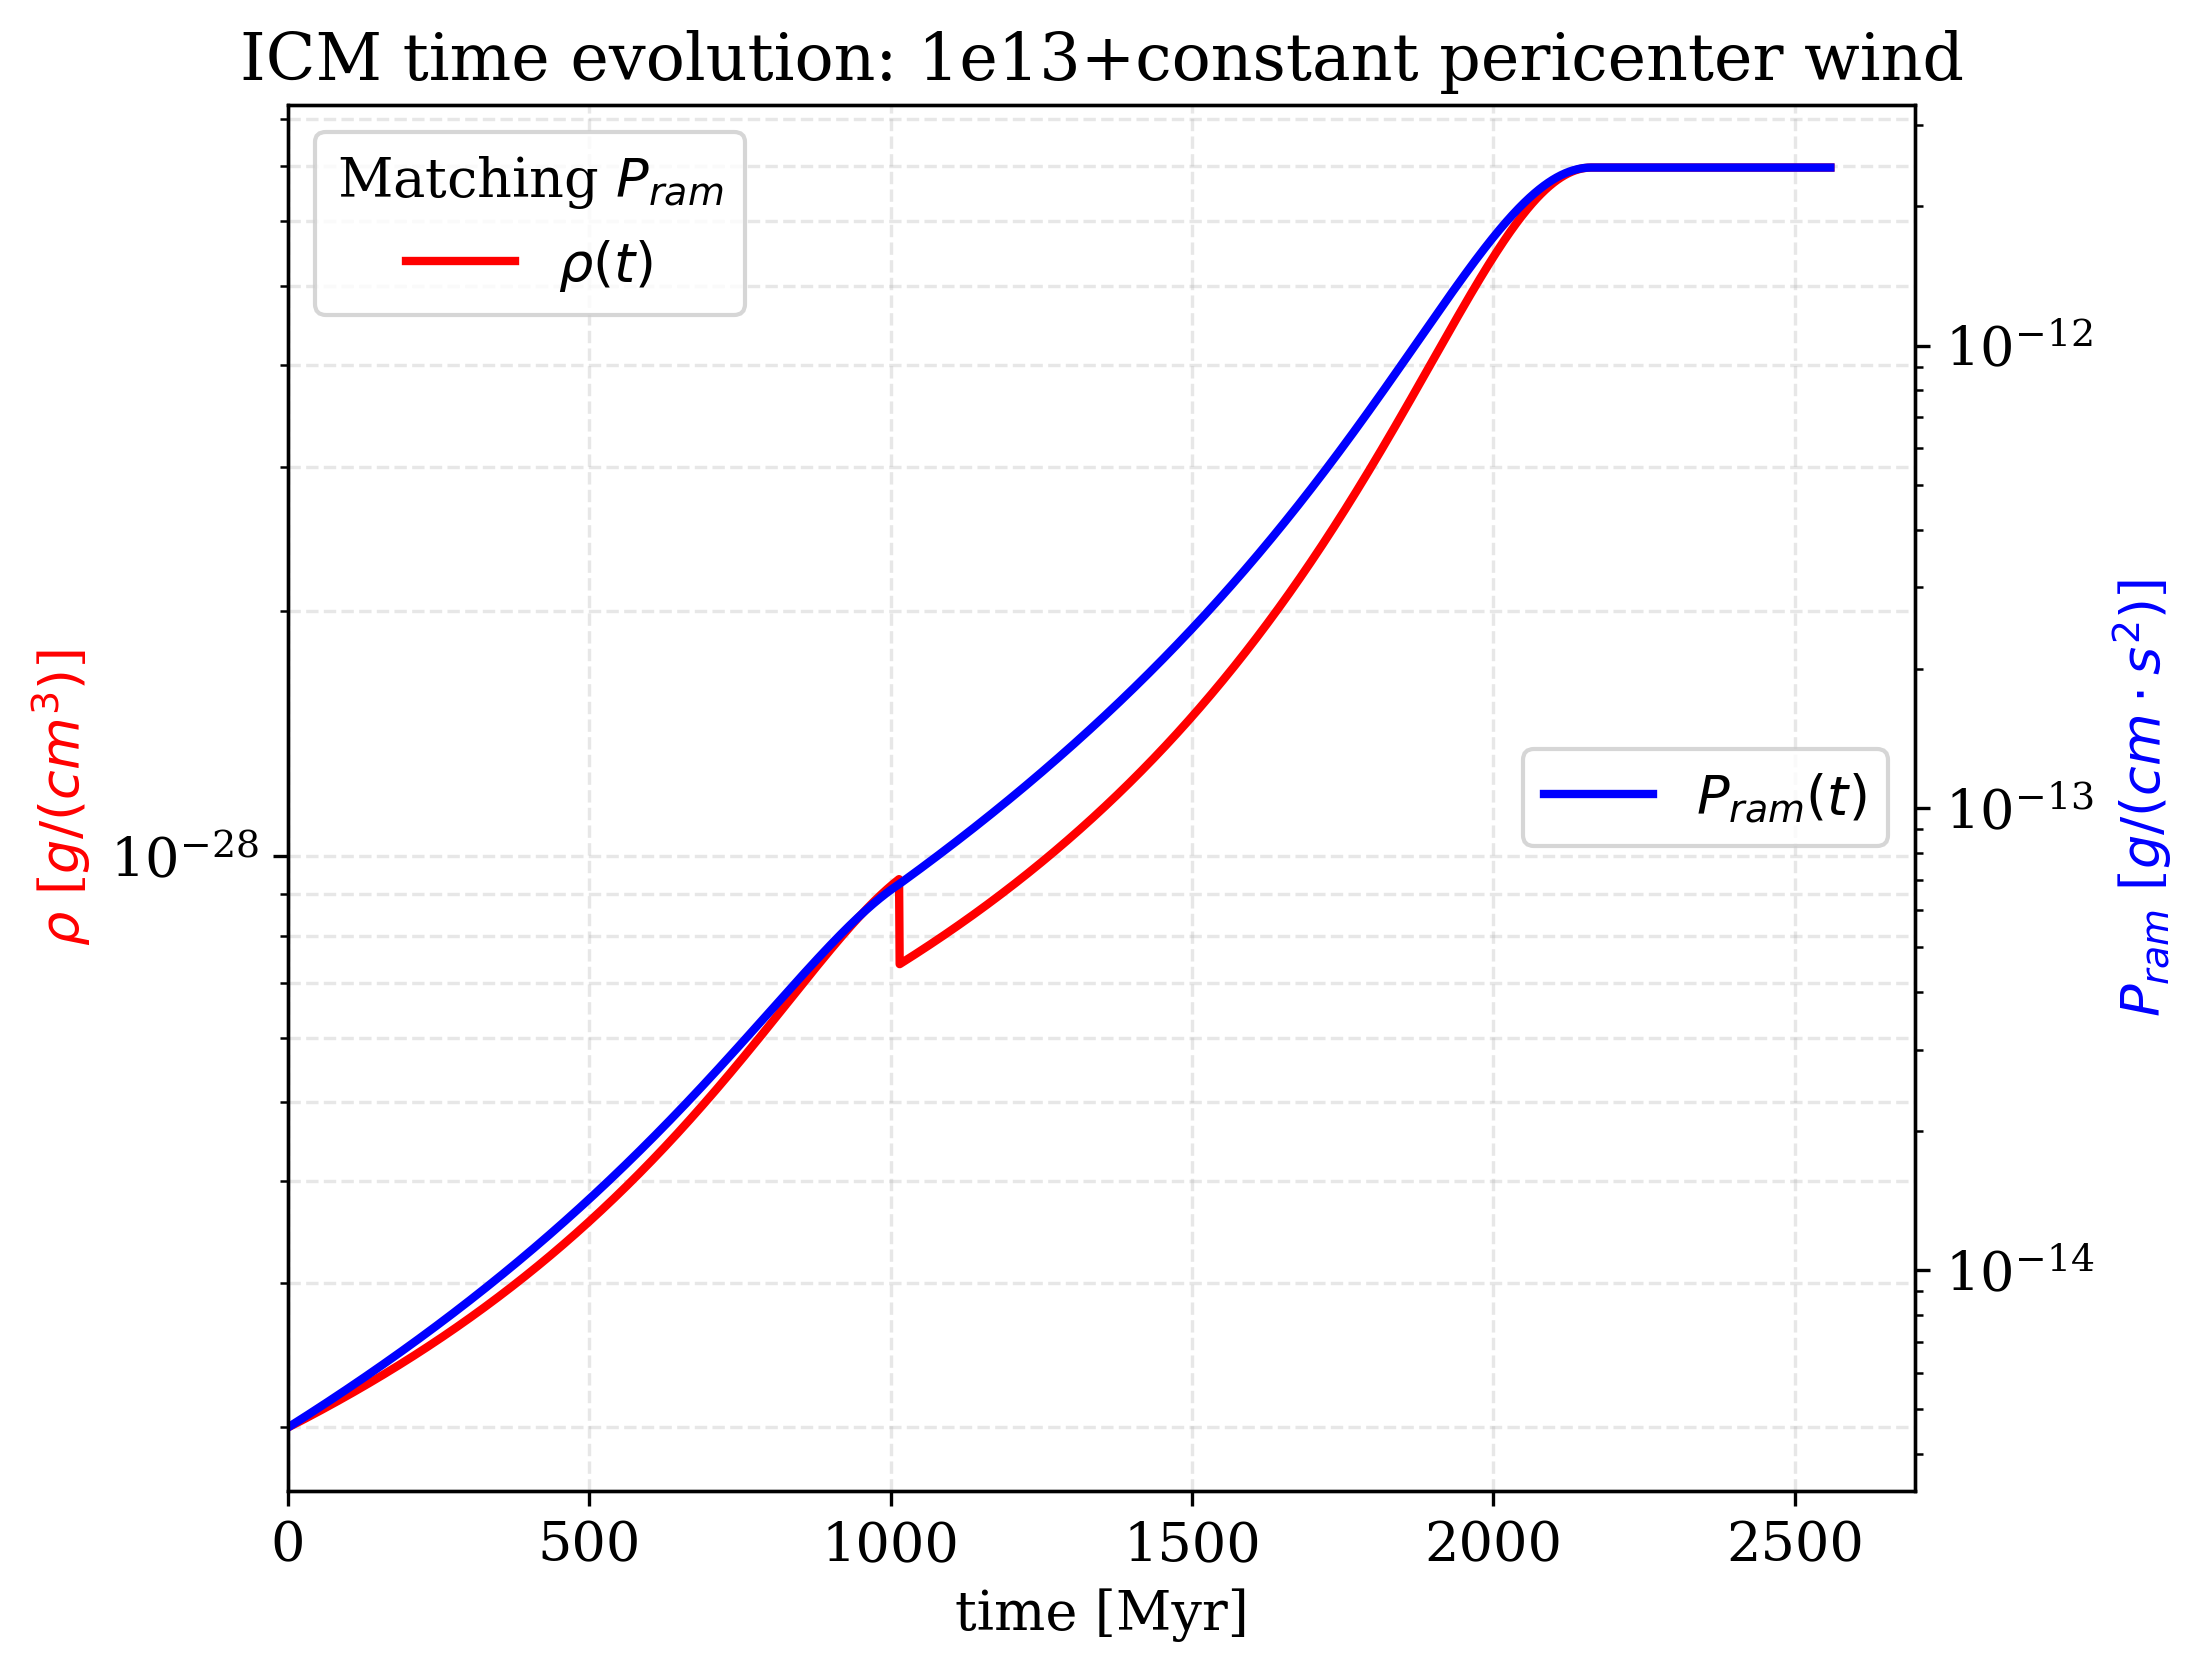

In [61]:
# the stacked time evolution

fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=300)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/(cm^{3})$]',color='r')

plt.title(r'ICM time evolution: 1e13+constant pericenter wind')

plt.plot(time_ts_1e13_pericenter_full/u.Myr.to(u.s), 
         rho_ts_1e13_pericenter_full, 'r-',lw=2,label=r'$\rho(t)$')


plt.yscale('log')
plt.xlim(0,2700)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e13_pericenter_full/u.Myr.to(u.s), 
         rho_ts_1e13_pericenter_full*(vy_ts_1e13_pericenter_full**2 + vz_ts_1e13_pericenter_full**2), 
        'b-',lw=2,label=r'$P_{ram}(t)$')
ax2.set_yscale('log')
ax2.set_ylabel(r'$P_{ram}$ [$g/(cm \cdot s^{2})$]',color='b')
ax2.legend(loc='center right')

#plt.savefig('ICM_profile_stack_1e13_pericenter_wind.png')
plt.show()

## generating the 1e14 cluster halo profile

In [62]:
time_ts_1e14[-1]/(u.Myr.to(u.s))

1143.0

In [63]:
# update 05/10: try matching ram pressure at 1062 Myr
# initiate the 1e13 run by restarting at 1e12 run, checkpoint No. 106, attach 1e13 time steps to 1e12 ICM inflow
# update 05/30: matching ram pressure at 542 Myr of the 1e13 run to initialize the 1e14 run

# calculate new time steps
#time_ts_1e13_attach = time_ts_1e12[1062] + time_ts_1e13

# note: initially ind_match_Pram_12_13 = 1062 and ind_match_Pram_13_14 = 542
# new version of gala yielded revised orbits
time_ts_1e14_attach = time_ts_1e13_attach[ind_match_Pram_13_14]  + time_ts_1e14 

# create the "full_evol" arrays for the 1e12+1e13+1e14 stacked profile
#time_ts_1e13_full_evol = np.hstack((time_ts_1e12[:ind_match_Pram_12_13], time_ts_1e13_attach))
#rho_ts_1e13_full_evol  = np.hstack((rho_ts_1e12[:ind_match_Pram_12_13], rho_ts_1e13))
time_ts_1e14_full_evol = np.hstack((time_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], time_ts_1e14_attach))
rho_ts_1e14_full_evol  = np.hstack((rho_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], rho_ts_1e14))


vx_ts_1e14_full_evol = np.hstack((vx_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], vx_ts_1e14)) 
vy_ts_1e14_full_evol = np.hstack((vy_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], vy_ts_1e14)) 
vz_ts_1e14_full_evol = np.hstack((vz_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], vz_ts_1e14)) 

temp_ts_1e14_full_evol = np.hstack((temp_ts_1e13_full_evol[:ind_match_Pram_12_13+ind_match_Pram_13_14], temp_ts_1e14))
print (time_ts_1e14_full_evol/u.Myr.to(u.s))

# write to a data file
'''
np.savetxt('ICMinflow_1e14_cluster_profile_45degree_wind_stacked_on_1e13_data.in', 
          np.column_stack([time_ts_1e14_full_evol, rho_ts_1e14_full_evol,temp_ts_1e14_full_evol,
                           vx_ts_1e14_full_evol, vy_ts_1e14_full_evol, vz_ts_1e14_full_evol]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

[0.000e+00 1.000e+00 2.000e+00 ... 2.683e+03 2.684e+03 2.685e+03]


'\nnp.savetxt(\'ICMinflow_1e14_cluster_profile_45degree_wind_stacked_on_1e13_data.in\', \n          np.column_stack([time_ts_1e14_full_evol, rho_ts_1e14_full_evol,temp_ts_1e14_full_evol,\n                           vx_ts_1e14_full_evol, vy_ts_1e14_full_evol, vz_ts_1e14_full_evol]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

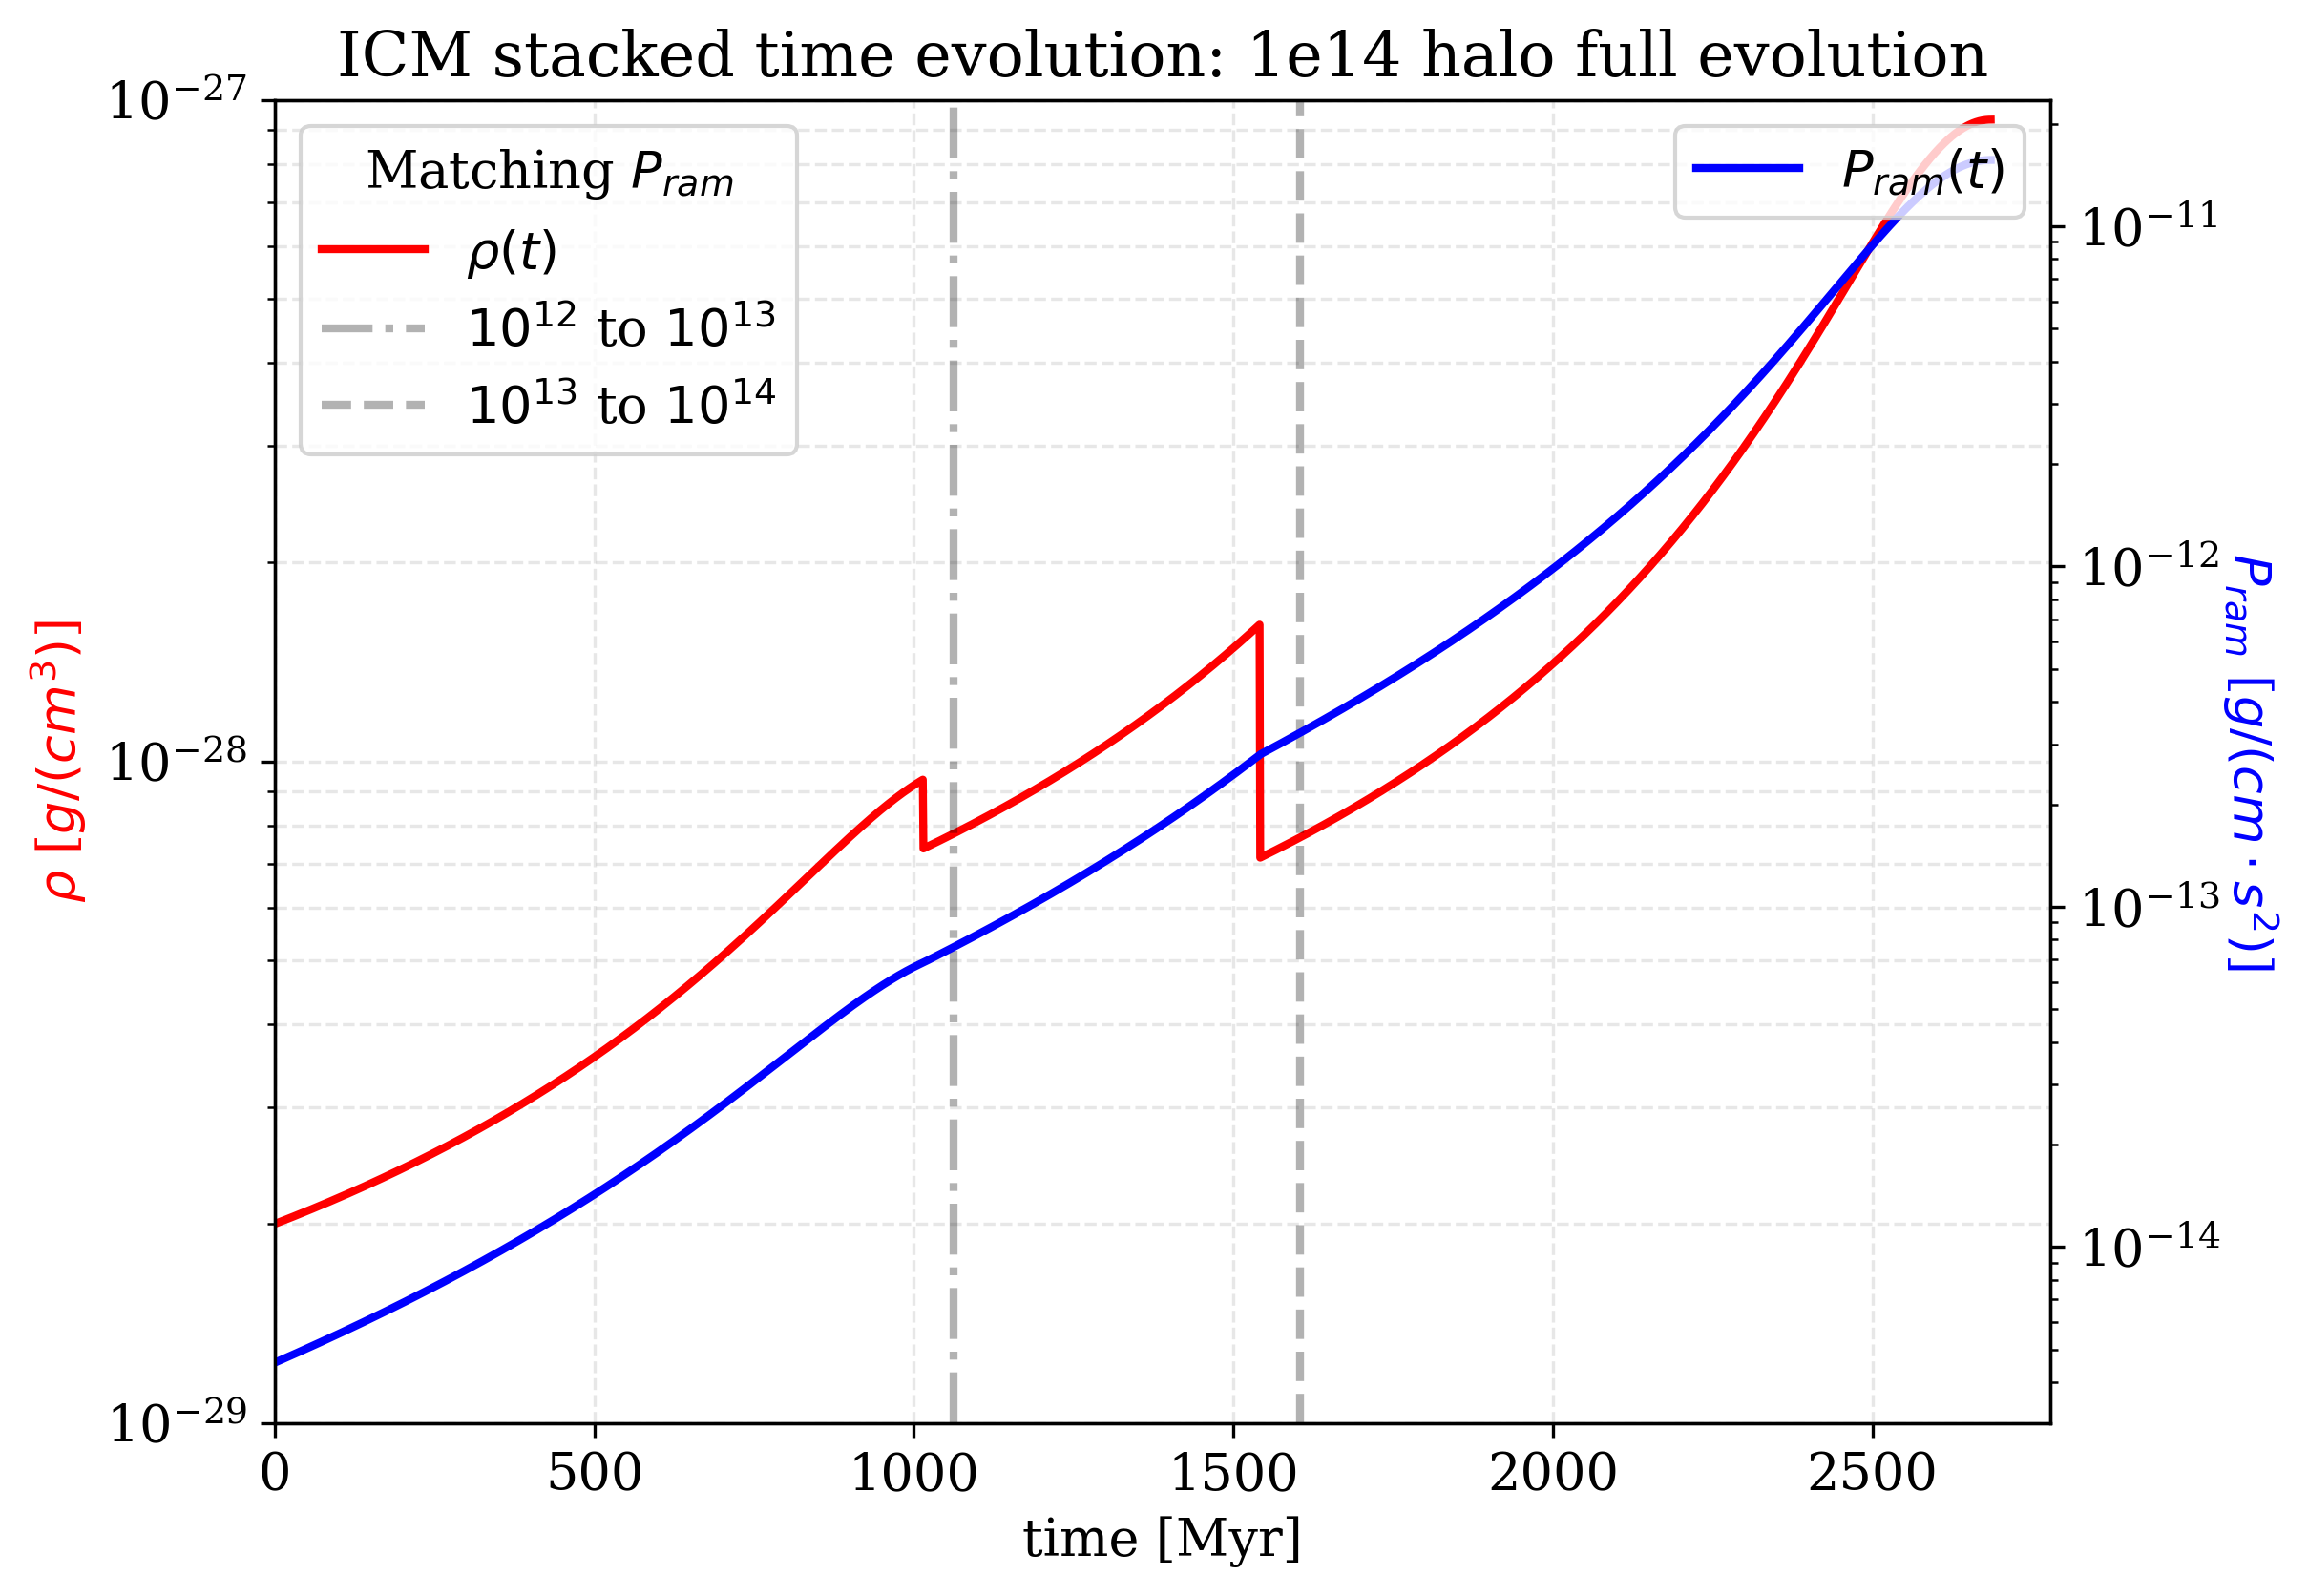

In [64]:
# the stacked time evolution
# 1e14 halo full evolution

fig,ax = plt.subplots(1, 1, figsize=(8,6),dpi=300)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/(cm^{3})$]',color='r')

plt.title(r'ICM stacked time evolution: 1e14 halo full evolution')

plt.plot(time_ts_1e14_full_evol/u.Myr.to(u.s), 
         rho_ts_1e14_full_evol, 'r-',lw=2,label=r'$\rho(t)$')
plt.axvline(x=1062, color='k',ls='-.',lw=2, alpha=0.3,label=r'$10^{12}$ to $10^{13}$')
plt.axvline(x=1062+542, color='k',ls='--',lw=2, alpha=0.3, label=r'$10^{13}$ to $10^{14}$')


plt.yscale('log')
plt.ylim(1e-29, 1e-27)
plt.xlim(0,1062+542+1164+10)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e14_full_evol/u.Myr.to(u.s), 
         rho_ts_1e14_full_evol*(vy_ts_1e14_full_evol**2 + vz_ts_1e14_full_evol**2), 
        'b-',lw=2,label=r'$P_{ram}(t)$')
ax2.set_yscale('log')
ax2.set_ylabel(r'$P_{ram}$ [$g/(cm \cdot s^{2})$]',color='b',rotation=270,labelpad=15)
ax2.legend(loc='upper right')

#plt.savefig('ICM_profile_stack_1e14.png')
plt.show()

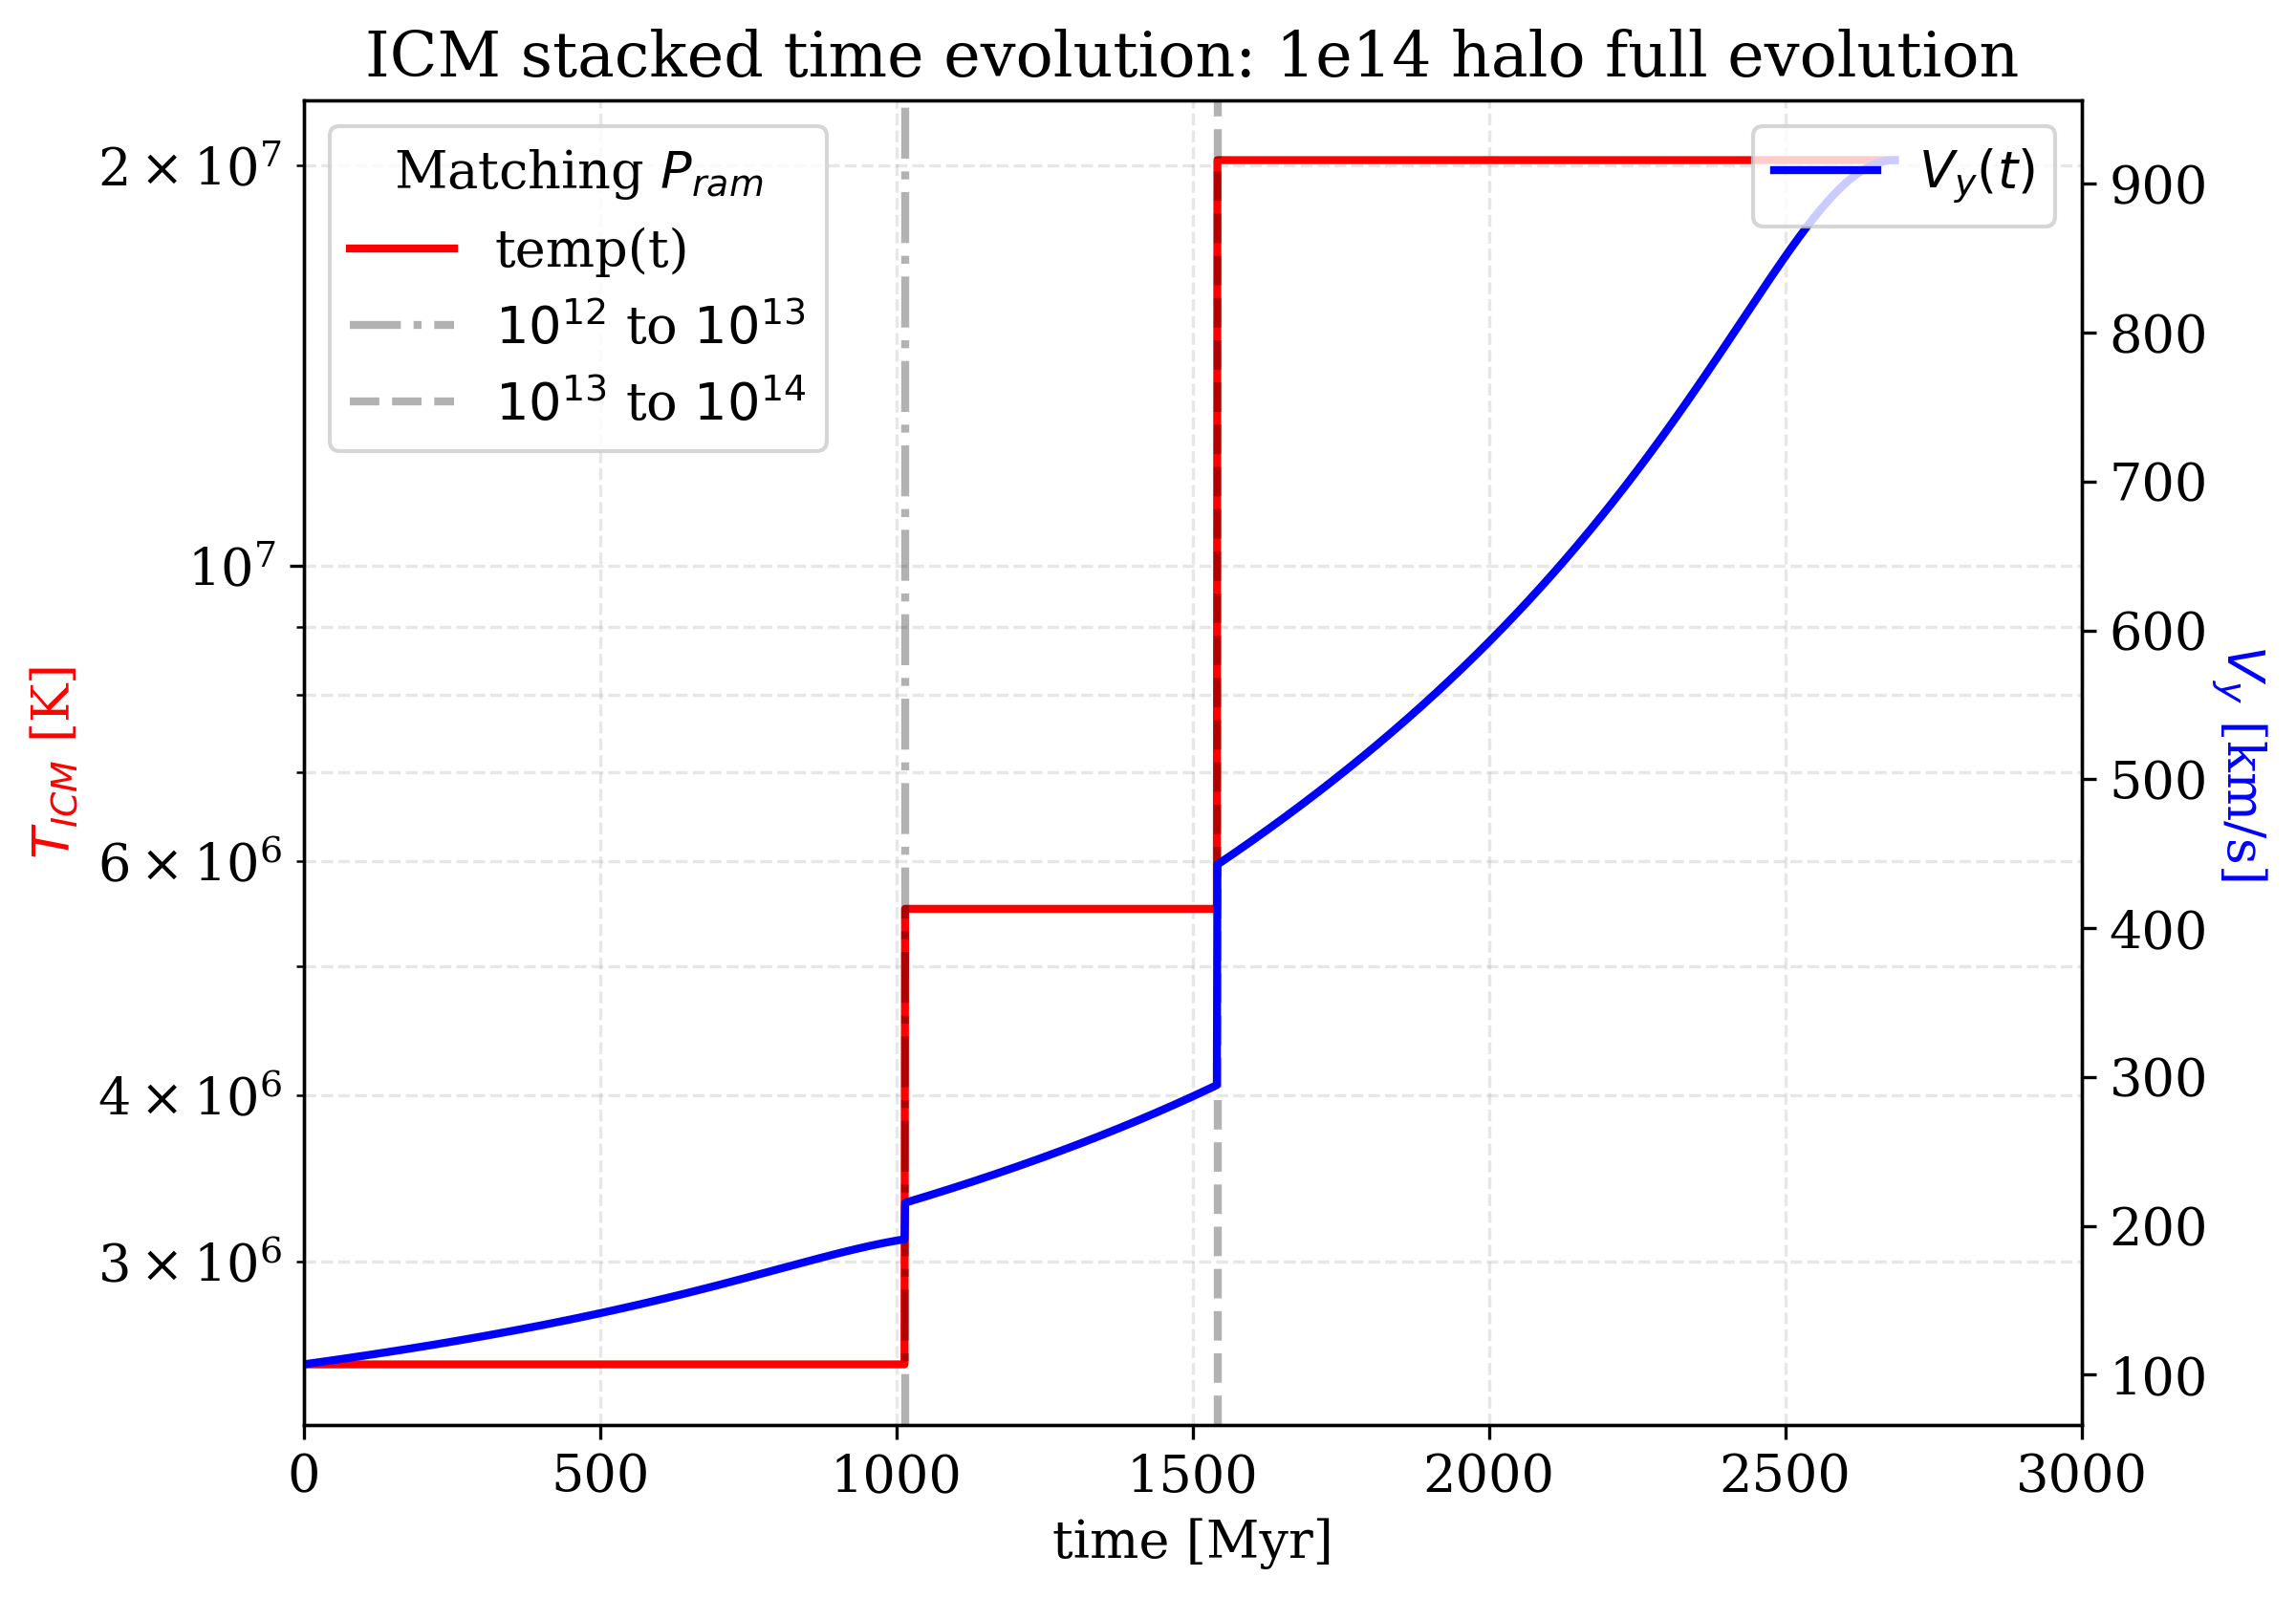

In [65]:
# the stacked time evolution
# 1e14 halo full evolution

fig,ax = plt.subplots(1, 1, figsize=(8,6),dpi=300)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$T_{ICM}$ [K]',color='r')

plt.title(r'ICM stacked time evolution: 1e14 halo full evolution')

plt.plot(time_ts_1e14_full_evol/u.Myr.to(u.s), 
         temp_ts_1e14_full_evol, 'r-',lw=2,label=r'temp(t)')
plt.axvline(x=ind_match_Pram_12_13, color='k',ls='-.',lw=2, alpha=0.3,label=r'$10^{12}$ to $10^{13}$')
plt.axvline(x=ind_match_Pram_12_13+ind_match_Pram_13_14,
            color='k',ls='--',lw=2, alpha=0.3, label=r'$10^{13}$ to $10^{14}$')


plt.yscale('log')
#plt.ylim(1e-29, 1e-27)
plt.xlim(0,3000)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e14_full_evol/u.Myr.to(u.s), 
         vy_ts_1e14_full_evol/1e5, 
        'b-',lw=2,label=r'$V_{y}(t)$')
#ax2.set_yscale('log')
ax2.set_ylabel(r'$V_{y}$ [km/s]',color='b',rotation=270,labelpad=15)
ax2.legend(loc='upper right')

#plt.savefig('ICM_profile_stack_1e14.png')
plt.show()

### update 06/30 (potentially) append a constant pericenter for the 1e14 already highly stripped case?

In [66]:
print ('time needed for pericenter wind to travel through (half-)simulation box: [Myr] \n',
       5.e23/2./vy_ts_1e14_full_evol[-1]/(u.Myr.to(u.s)),'\n',
      5.e23/vy_ts_1e14_full_evol[-1]/(u.Myr.to(u.s)))

print ('Conclusion: \n',
      '9 checkpoints (~90 Myr) for wind to reach half box \n',
      '18 checkpoints (~180 Myr) for full box')

time needed for pericenter wind to travel through (half-)simulation box: [Myr] 
 86.49217005500196 
 172.98434011000393
Conclusion: 
 9 checkpoints (~90 Myr) for wind to reach half box 
 18 checkpoints (~180 Myr) for full box


In [67]:
# update 06/30: attaching a constant pericenter wind (~181 Myr) to the 1e14 case

time_ts_1e14_pericenter_attach = time_ts_1e14_full_evol[-1] + time_ts_1e14[1:182]


# create the "pericenter" arrays on top of the 1e12+1e13 stacked profile
time_ts_1e14_pericenter_full = np.hstack((time_ts_1e14_full_evol, time_ts_1e14_pericenter_attach))
rho_ts_1e14_pericenter_full  = np.hstack((rho_ts_1e14_full_evol,  np.array([rho_ts_1e14_full_evol[-1]]*181)))

vx_ts_1e14_pericenter_full = np.hstack((vx_ts_1e14_full_evol, np.array([vx_ts_1e14_full_evol[-1]]*181))) 
vy_ts_1e14_pericenter_full = np.hstack((vy_ts_1e14_full_evol, np.array([vy_ts_1e14_full_evol[-1]]*181))) 
vz_ts_1e14_pericenter_full = np.hstack((vz_ts_1e14_full_evol, np.array([vz_ts_1e14_full_evol[-1]]*181))) 


temp_ts_1e14_pericenter_full  = np.hstack((temp_ts_1e14_full_evol,  np.array([temp_ts_1e14_full_evol[-1]]*181)))


# write to a data file
'''
np.savetxt('ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in', 
          np.column_stack([time_ts_1e14_pericenter_full,
                           rho_ts_1e14_pericenter_full,
                           temp_ts_1e14_pericenter_full,
                           vx_ts_1e14_pericenter_full,
                           vy_ts_1e14_pericenter_full,
                           vz_ts_1e14_pericenter_full]),
          fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')
'''

'\nnp.savetxt(\'ICMinflow_1e14_group_profile_45degree_wind_stacked_pericenter_data.in\', \n          np.column_stack([time_ts_1e14_pericenter_full,\n                           rho_ts_1e14_pericenter_full,\n                           temp_ts_1e14_pericenter_full,\n                           vx_ts_1e14_pericenter_full,\n                           vy_ts_1e14_pericenter_full,\n                           vz_ts_1e14_pericenter_full]),\n          fmt=\'%.10e\',delimiter="  ",header=\'time    Density         Temp    Velocity (x,y,z) \')\n'

In [68]:
time_ts_1e14_full_evol.shape[0]+181

2867

In [1]:
# the stacked time evolution

fig,ax = plt.subplots(1, 1, figsize=(7,6),dpi=150)
plt.rc('font', size=13)
plt.grid(True, which='both', alpha=0.3, linestyle='--')

plt.xlabel('time [Myr]')
plt.ylabel(r'$\rho$ [$g/(cm^{3})$]',color='r')

plt.title(r'ICM time evolution: 1e13+constant pericenter wind')

plt.plot(time_ts_1e14_pericenter_full/u.Myr.to(u.s), 
         rho_ts_1e14_pericenter_full, 'r-',lw=2,label=r'$\rho(t)$')


#plt.axvline(x=2769, color='k',ls='-.',lw=2, alpha=0.3,label='time of const. peri-wind stack')
plt.yscale('log')
plt.xlim(0,3000)

plt.legend(loc='upper left',title=r'Matching $P_{ram}$')
ax2 = ax.twinx()
ax2.plot(time_ts_1e14_pericenter_full/u.Myr.to(u.s), 
         rho_ts_1e14_pericenter_full*(vy_ts_1e14_pericenter_full**2 + vz_ts_1e14_pericenter_full**2), 
        'b-',lw=2,label=r'$P_{ram}(t)$')
ax2.set_yscale('log')
ax2.set_ylabel(r'$P_{ram}$ [$g/(cm \cdot s^{2})$]',color='b')
ax2.legend(loc='center right')

#plt.savefig('ICM_profile_stack_1e14_pericenter_wind.png')
plt.show()

NameError: name 'plt' is not defined